In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_quality_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = load_air_quality_data()
print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

dataframe shape (9357, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date_Time    9357 non-null   object 
 1   CO_true      9357 non-null   float64
 2   CO_sensor    9357 non-null   float64
 3   NMHC_true    9357 non-null   float64
 4   C6H6_true    9357 non-null   float64
 5   NMHC_sensor  9357 non-null   float64
 6   NOX_true     9357 non-null   float64
 7   NOX_sensor   9357 non-null   float64
 8   NO2_true     9357 non-null   float64
 9   NO2_sensor   9357 non-null   float64
 10  O3_sensor    9357 non-null   float64
 11  T            9357 non-null   float64
 12  RH           9357 non-null   float64
 13  AH           9357 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1023.6+ KB
None


,Date_Time,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [4]:
dataframe = (
    load_air_quality_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="6H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (9357, 14)
set_index: DF Shape (9357, 13)
interpolate_columns: DF Shape (9357, 13)
resample_Data: DF Shape (1560, 13)
dataframe shape (1560, 13)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1560 entries, 2004-03-10 18:00:00 to 2005-04-04 12:00:00
Freq: 6H
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CO_true      1560 non-null   float64
 1   CO_sensor    1560 non-null   float64
 2   NMHC_true    1560 non-null   float64
 3   C6H6_true    1560 non-null   float64
 4   NMHC_sensor  1560 non-null   float64
 5   NOX_true     1560 non-null   float64
 6   NOX_sensor   1560 non-null   float64
 7   NO2_true     1560 non-null   float64
 8   NO2_sensor   1560 non-null   float64
 9   O3_sensor    1560 non-null   float64
 10  T            1560 non-null   float64
 11  RH           1560 non-null   float64
 12  AH           1560 non-null   float64
dtypes: float64(13)
memory usage: 170.6 KB
None

,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,1.966667,1316.500000,86.500000,8.450000,912.333333,132.000000,1167.333333,108.833333,1545.500000,1096.000000,12.033333,54.900000,0.765633
2004-03-11 00:00:00,-32.600000,1083.666667,21.166667,2.216667,595.166667,1.000000,1655.833333,12.500000,1259.333333,575.166667,10.683333,58.900000,0.755017
2004-03-11 06:00:00,1.533333,1215.333333,52.666667,5.600000,778.166667,107.000000,1331.500000,88.833333,1411.333333,810.500000,10.550000,58.666667,0.746217
2004-03-11 12:00:00,2.283333,1313.000000,102.000000,8.716667,923.666667,179.500000,1106.500000,121.166667,1604.166667,917.833333,8.933333,73.816667,0.843533
2004-03-11 18:00:00,4.033333,1364.666667,242.166667,15.383333,1110.833333,232.666667,1015.166667,127.000000,1816.500000,1237.500000,9.183333,64.916667,0.758300


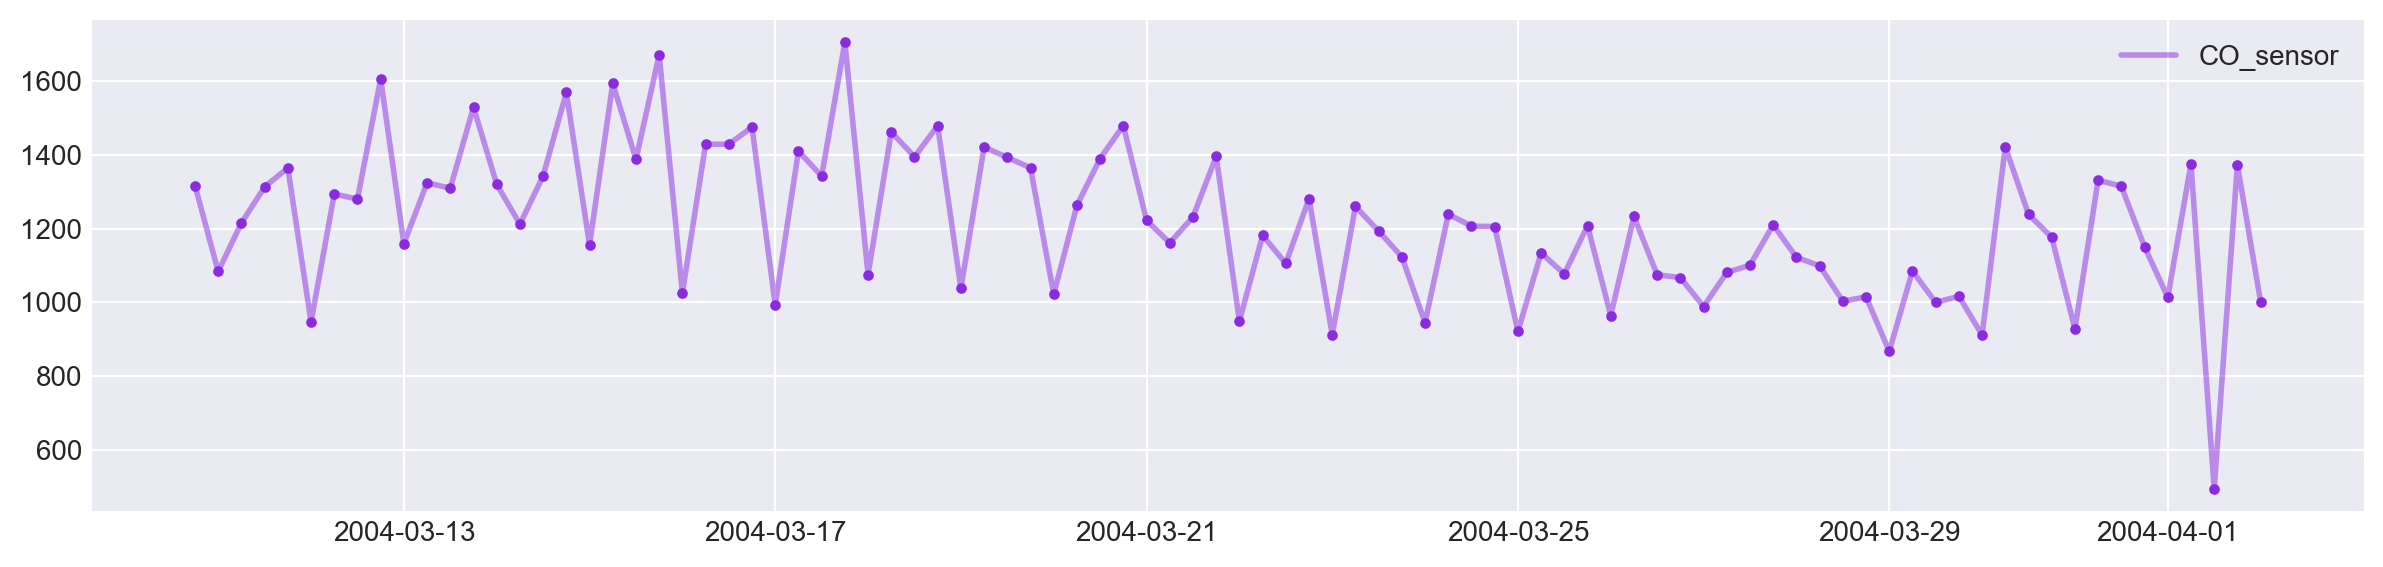

In [5]:
show_dataset(dataframe[:90], columns=["CO_sensor"])

In [7]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "CO_sensor"
TEST_SIZE = 30

In [9]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (1530, 13)
Test  Size after Test_Train Split: (30, 13) 
train_data shape after Feature Union (1530, 32)
test_data shape after Feature Union (30, 32)
train_data shape after Null Removal (1528, 32)
test_data shape after Null Removal (30, 32)


,CO_true,CO_sensor,NMHC_true,C6H6_true,NMHC_sensor,NOX_true,NOX_sensor,NO2_true,NO2_sensor,O3_sensor,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-28 06:00:00,1.166667,1049.000000,-200.0,4.000000,703.666667,172.166667,772.000000,93.833333,1277.000000,835.333333,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-28 12:00:00,1.383333,1080.166667,-200.0,4.400000,729.833333,168.000000,756.500000,92.666667,1248.500000,691.000000,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-28 18:00:00,2.416667,1182.166667,-200.0,8.450000,911.666667,330.500000,624.833333,141.000000,1355.166667,1072.333333,...,28.0,13.0,0.0,1.0,0.270906,-0.962606,0.14112,-0.989992,-0.821818,0.569750
2005-03-29 00:00:00,-32.616667,936.833333,-200.0,2.383333,602.500000,104.666667,917.333333,68.333333,1155.000000,747.833333,...,29.0,13.0,0.0,1.0,-0.663634,-0.748058,0.14112,-0.989992,0.035398,0.999373
2005-03-29 06:00:00,3.183333,1302.833333,-200.0,15.033333,1126.166667,458.333333,511.666667,132.166667,1598.166667,1370.833333,...,29.0,13.0,0.0,1.0,-0.663634,-0.748058,0.14112,-0.989992,0.035398,0.999373


In [10]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.881 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.840 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.859 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.896 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.842 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.882 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.894 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.830 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.897 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.892 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.819 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

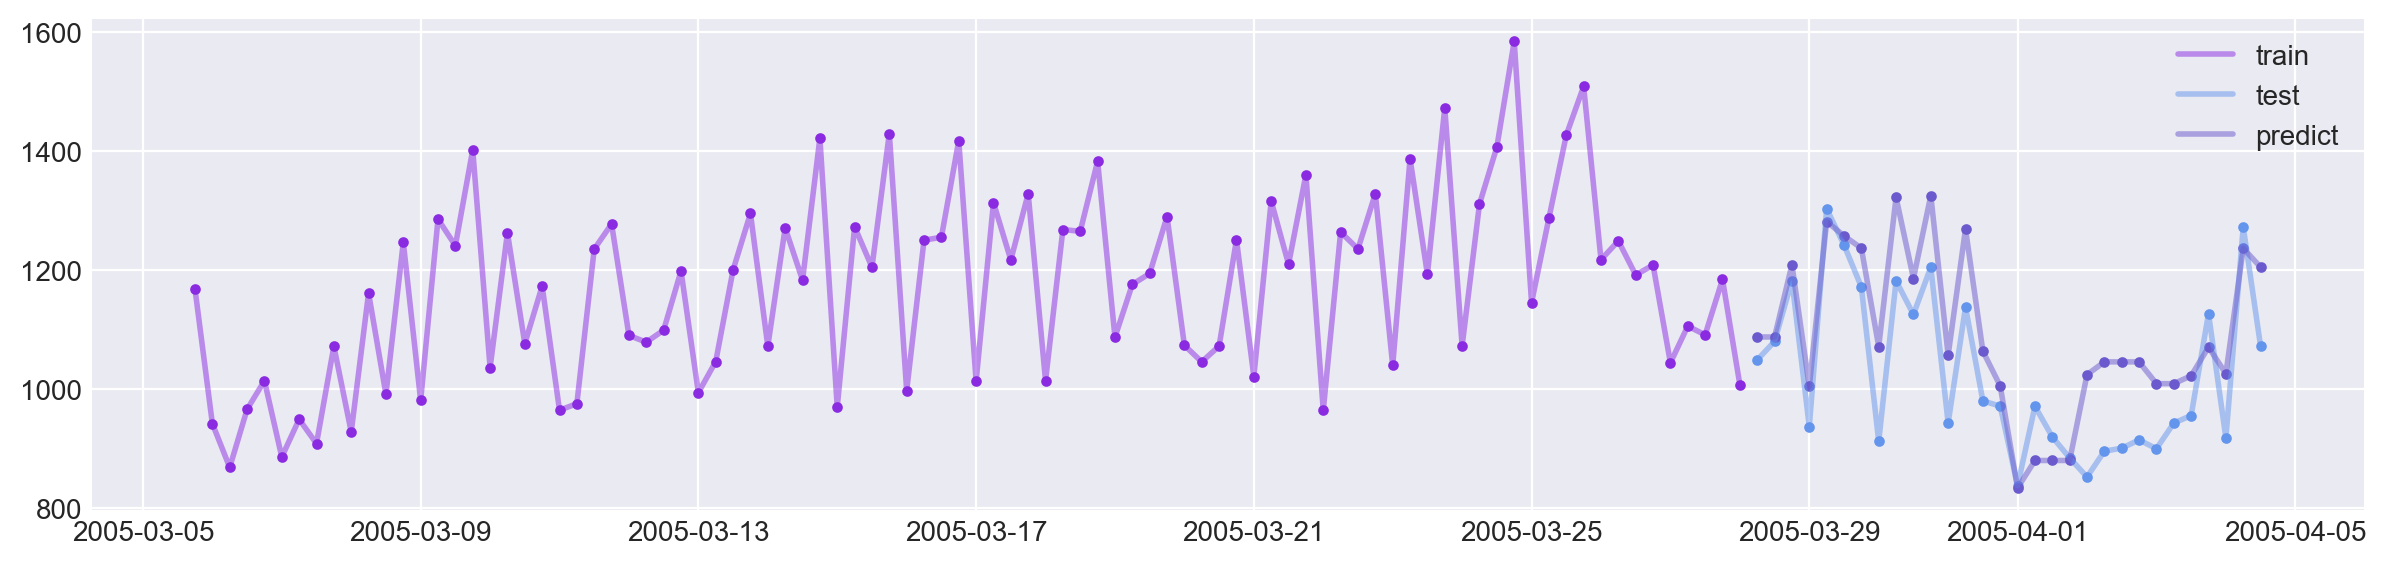

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [14]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  6  iterations


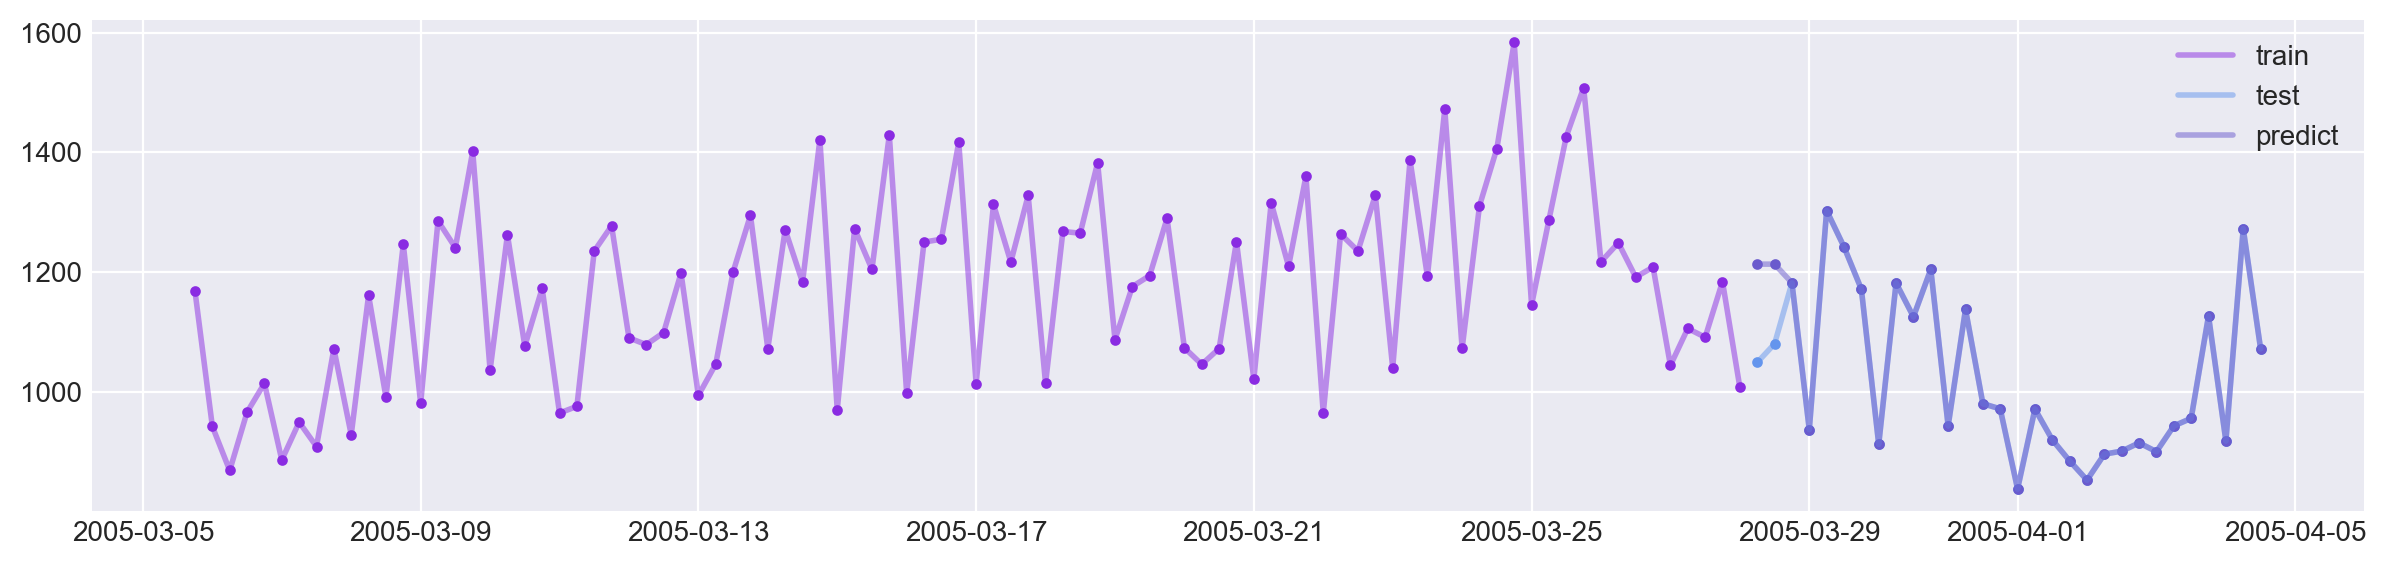

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [16]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

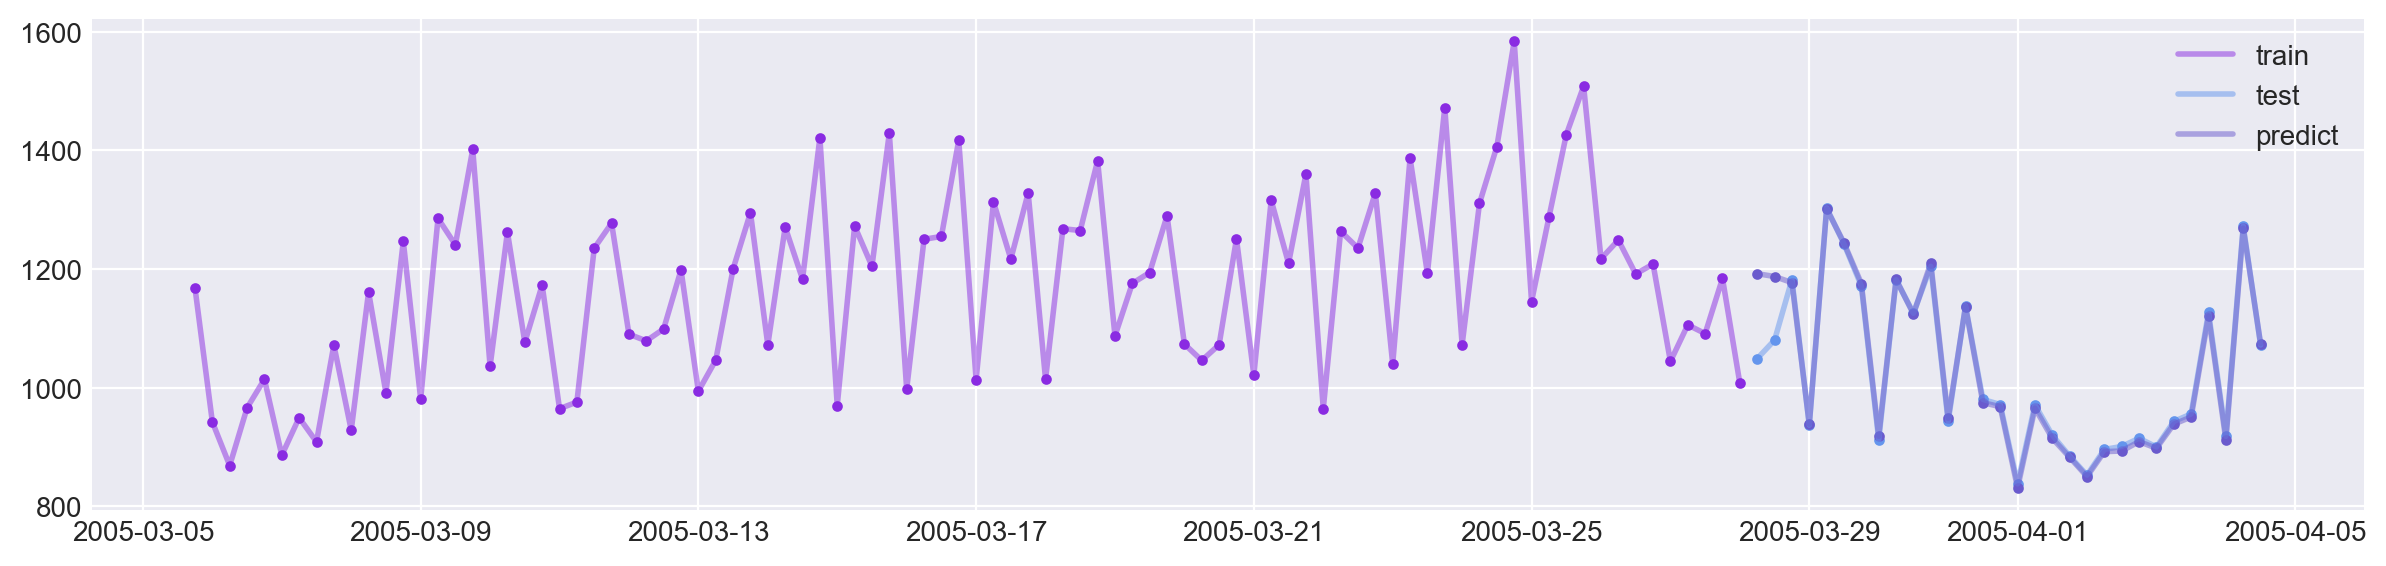

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.955 total time=   1.2s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.952 total time=   2.4s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.976 total time=   3.9s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.955 total time=   2.1s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.953 total time=   6.6s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.977 total time=   6.8s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.955 total time=   2.9s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.954 total time=   5.3s
[C

[CV 2/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.955 total time=   5.4s
[CV 3/3] END max_depth=8, min_samples_leaf=3, min_samples_split=8, n_estimators=600;, score=0.977 total time=   9.2s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.955 total time=   1.6s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.955 total time=   3.1s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.977 total time=   4.8s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.956 total time=   2.3s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.956 total time=   5.3s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.978 total time=   8.5s
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=

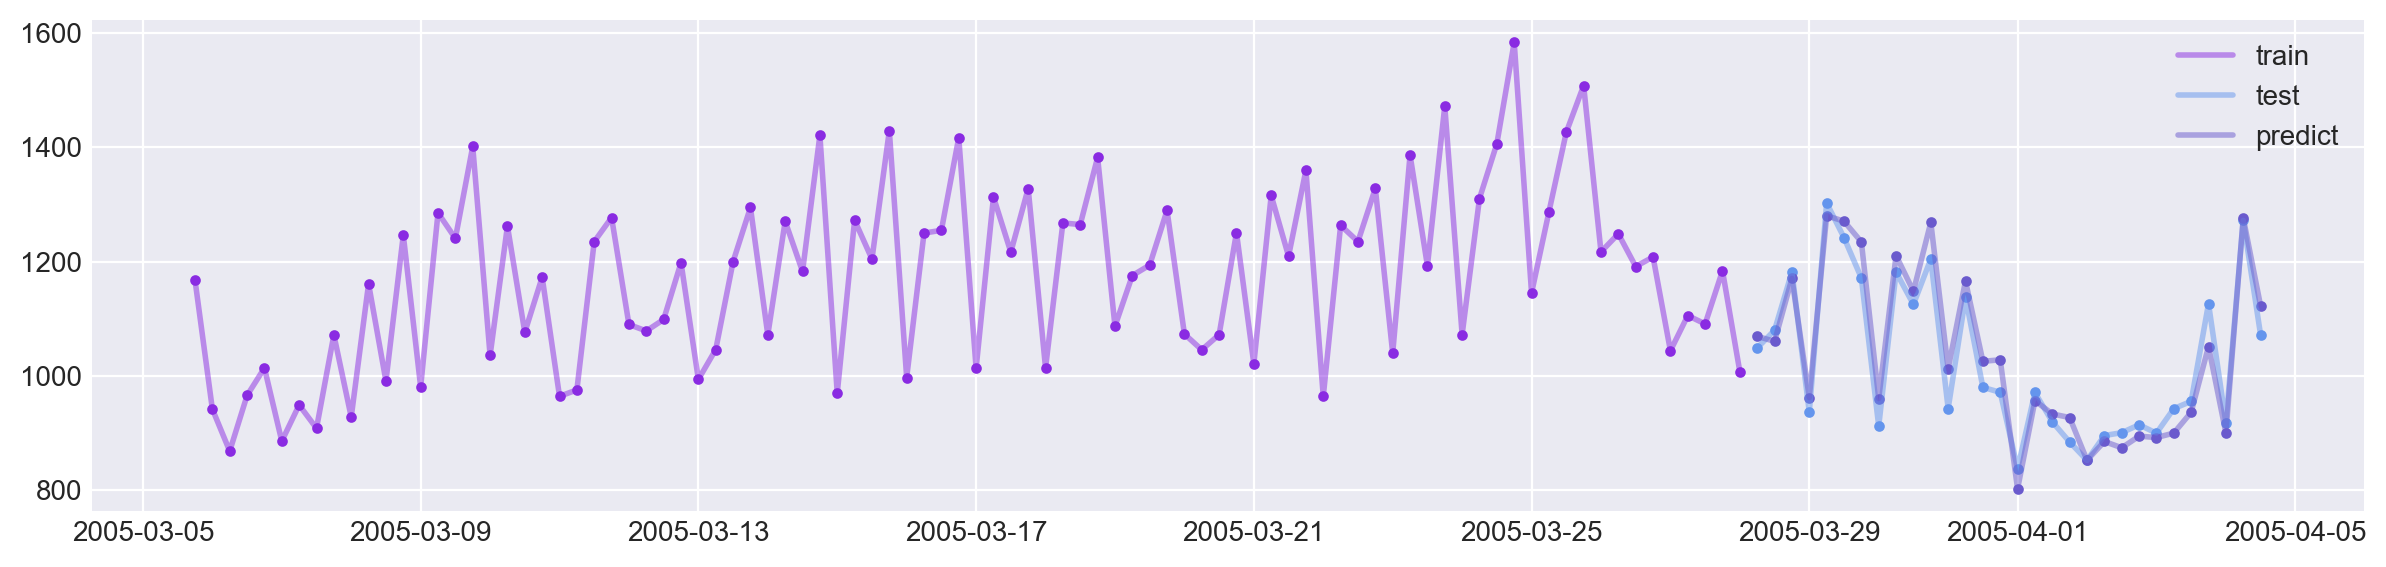

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:1051.56258	validation_1-mae:1015.67979
[1]	validation_0-mae:1041.09882	validation_1-mae:1005.72264
[2]	validation_0-mae:1030.74007	validation_1-mae:995.88489
[3]	validation_0-mae:1020.48379	validation_1-mae:986.25442
[4]	validation_0-mae:1010.32943	validation_1-mae:976.71071
[5]	validation_0-mae:1000.27609	validation_1-mae:967.16455
[6]	validation_0-mae:990.32370	validation_1-mae:957.71344
[7]	validation_0-mae:980.47600	validation_1-mae:948.46437
[8]	validation_0-mae:970.72069	validation_1-mae:939.20080
[9]	validation_0-mae:961.06138	validation_1-mae:930.07909
[10]	validation_0-mae:951.49756	validation_1-mae:921.00248
[11]	validation_0-mae:942.03538	validation_1-mae:912.07139
[12]	validation_0-mae:932.66083	validation_1-mae:903.12023
[13]	validation_0-mae:923.38267	validation_1-mae:894.29386
[14]	validation_0-mae:914.20086	validation_1-mae:885.66583
[15]	validation_0-mae:905.11103	validation_1-mae:877.03992
[16]	validation_0-mae:896.10705	validation_1-mae:868.47565

[139]	validation_0-mae:262.83932	validation_1-mae:251.82945
[140]	validation_0-mae:260.24175	validation_1-mae:249.21711
[141]	validation_0-mae:257.66887	validation_1-mae:246.59293
[142]	validation_0-mae:255.12115	validation_1-mae:244.00676
[143]	validation_0-mae:252.59720	validation_1-mae:241.48366
[144]	validation_0-mae:250.10206	validation_1-mae:238.97214
[145]	validation_0-mae:247.63630	validation_1-mae:236.51640
[146]	validation_0-mae:245.19058	validation_1-mae:234.04500
[147]	validation_0-mae:242.76806	validation_1-mae:231.53425
[148]	validation_0-mae:240.36579	validation_1-mae:229.12860
[149]	validation_0-mae:237.99152	validation_1-mae:226.67333
[150]	validation_0-mae:235.64114	validation_1-mae:224.29635
[151]	validation_0-mae:233.31112	validation_1-mae:222.00000
[152]	validation_0-mae:231.00460	validation_1-mae:219.64479
[153]	validation_0-mae:228.72438	validation_1-mae:217.35497
[154]	validation_0-mae:226.46499	validation_1-mae:215.14978
[155]	validation_0-mae:224.22519	validat

[278]	validation_0-mae:66.77090	validation_1-mae:53.76809
[279]	validation_0-mae:66.13299	validation_1-mae:53.21649
[280]	validation_0-mae:65.50414	validation_1-mae:52.58818
[281]	validation_0-mae:64.88189	validation_1-mae:51.98042
[282]	validation_0-mae:64.26751	validation_1-mae:51.41994
[283]	validation_0-mae:63.66107	validation_1-mae:50.86497
[284]	validation_0-mae:63.05572	validation_1-mae:50.36971
[285]	validation_0-mae:62.46270	validation_1-mae:49.82385
[286]	validation_0-mae:61.87690	validation_1-mae:49.30599
[287]	validation_0-mae:61.29711	validation_1-mae:48.76503
[288]	validation_0-mae:60.72152	validation_1-mae:48.23685
[289]	validation_0-mae:60.15515	validation_1-mae:47.75938
[290]	validation_0-mae:59.59099	validation_1-mae:47.30041
[291]	validation_0-mae:59.03712	validation_1-mae:46.82520
[292]	validation_0-mae:58.49109	validation_1-mae:46.35499
[293]	validation_0-mae:57.95167	validation_1-mae:45.96330
[294]	validation_0-mae:57.41773	validation_1-mae:45.56365
[295]	validati

[420]	validation_0-mae:23.86747	validation_1-mae:31.50477
[421]	validation_0-mae:23.74502	validation_1-mae:31.50261
[422]	validation_0-mae:23.62359	validation_1-mae:31.54952
[423]	validation_0-mae:23.52654	validation_1-mae:31.56183
[424]	validation_0-mae:23.40797	validation_1-mae:31.66521
[425]	validation_0-mae:23.29017	validation_1-mae:31.71115
[426]	validation_0-mae:23.18495	validation_1-mae:31.72336
[427]	validation_0-mae:23.07230	validation_1-mae:31.78964
[428]	validation_0-mae:22.96128	validation_1-mae:31.88963
[429]	validation_0-mae:22.86111	validation_1-mae:31.86972
[430]	validation_0-mae:22.76148	validation_1-mae:31.91753
[431]	validation_0-mae:22.65539	validation_1-mae:31.98074
[432]	validation_0-mae:22.55050	validation_1-mae:32.07861
[433]	validation_0-mae:22.45605	validation_1-mae:32.05911
[434]	validation_0-mae:22.36344	validation_1-mae:32.15603
[435]	validation_0-mae:22.26302	validation_1-mae:32.21738
[436]	validation_0-mae:22.17077	validation_1-mae:32.26447
[437]	validati

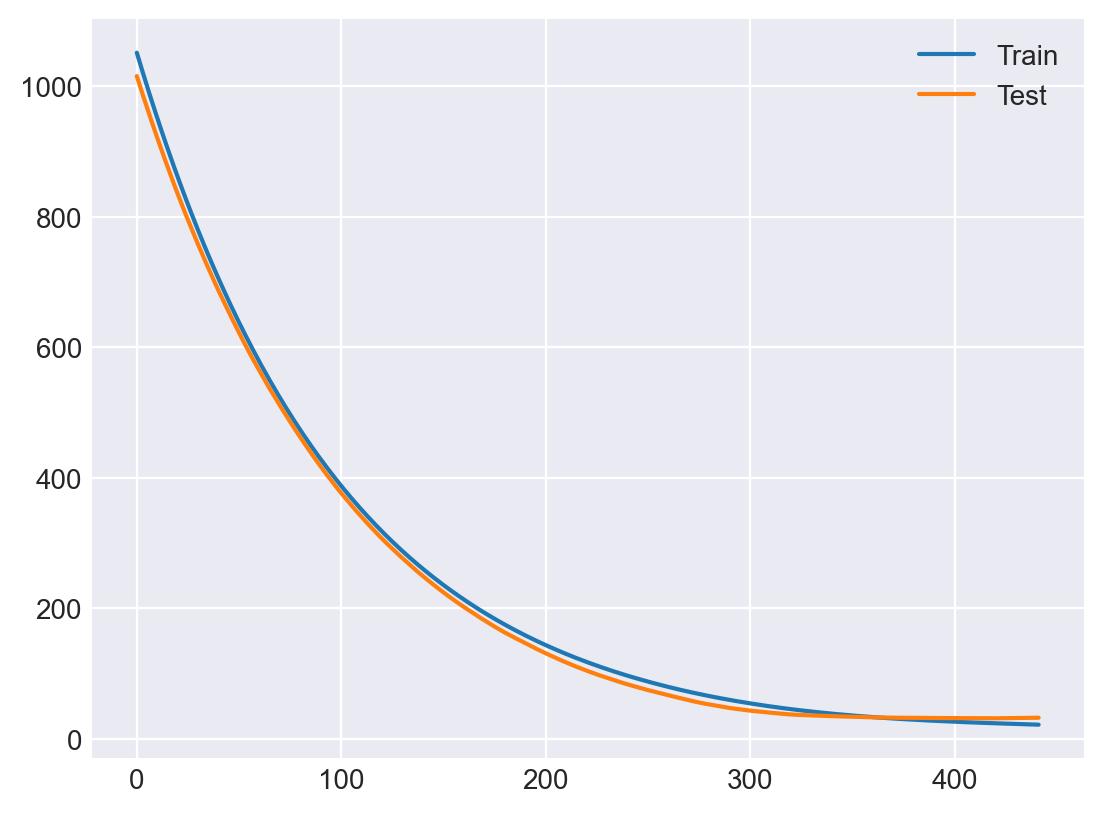

In [21]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

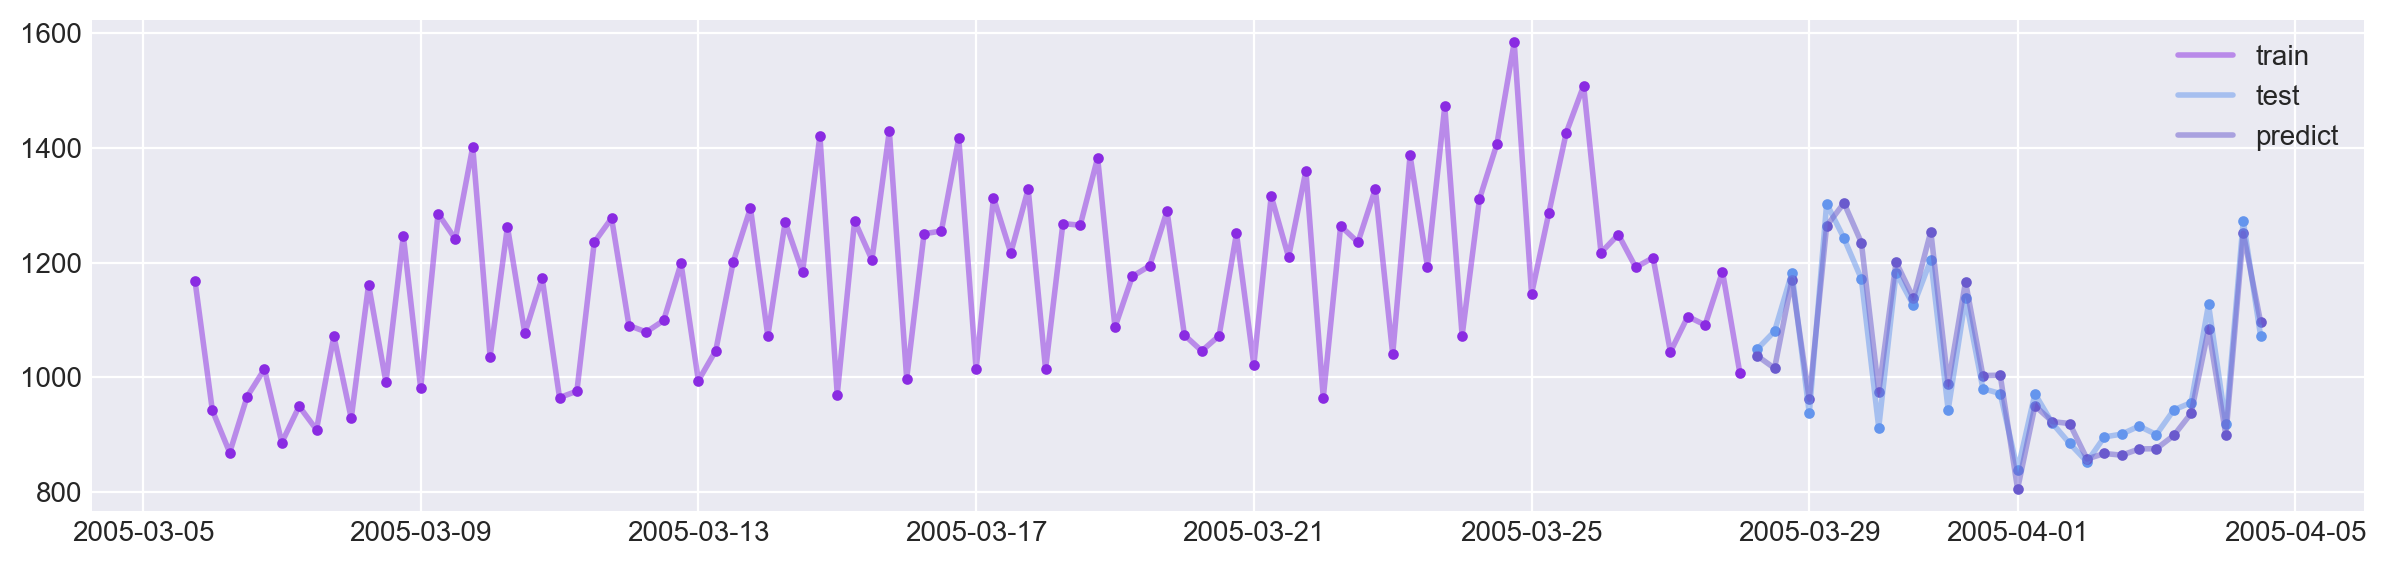

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [23]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\rdas6\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's l1: 178.425	training's l2: 76683.7	valid_1's l1: 111.613	valid_1's l2: 15100.7
[2]	training's l1: 161.689	training's l2: 62721.1	valid_1's l1: 100.88	valid_1's l2: 12308.5
[3]	training's l1: 146.764	training's l2: 51421.7	valid_1's l1: 91.1297	valid_1's l2: 10093.9
[4]	training's l1: 133.401	training's l2: 42267.5	valid_1's l1: 81.1376	valid_1's l2: 8102.49
[5]	training's l1: 121.428	training's l2: 34769.2	valid_1's l1: 72.7115	valid_1's l2: 6526.04
[6]	training's l1: 110.596	training's l2: 28631	valid_1's l1: 64.2249	valid_1's l2: 5144.58
[7]	training's l1: 100.979	training's l2: 23629.3	valid_1's l1: 57.6918	valid_1's l2: 4246.14
[8]	training's l1: 92.3053	training's l2: 19531.8	valid_1's l1: 51.586	valid_1's l2: 3548.21
[9]	training's l1: 84.4731	training's l2: 16175.8	valid_1's l1: 46.2164	valid_1's l2: 2955.39
[10]	training's l1: 77.3614	training's l2: 13420.5	valid_1's l1: 42.0515	valid_1's l2: 2597.15
[11]	training's l1: 70.946	training's l2: 11165.2	valid_1's l1:

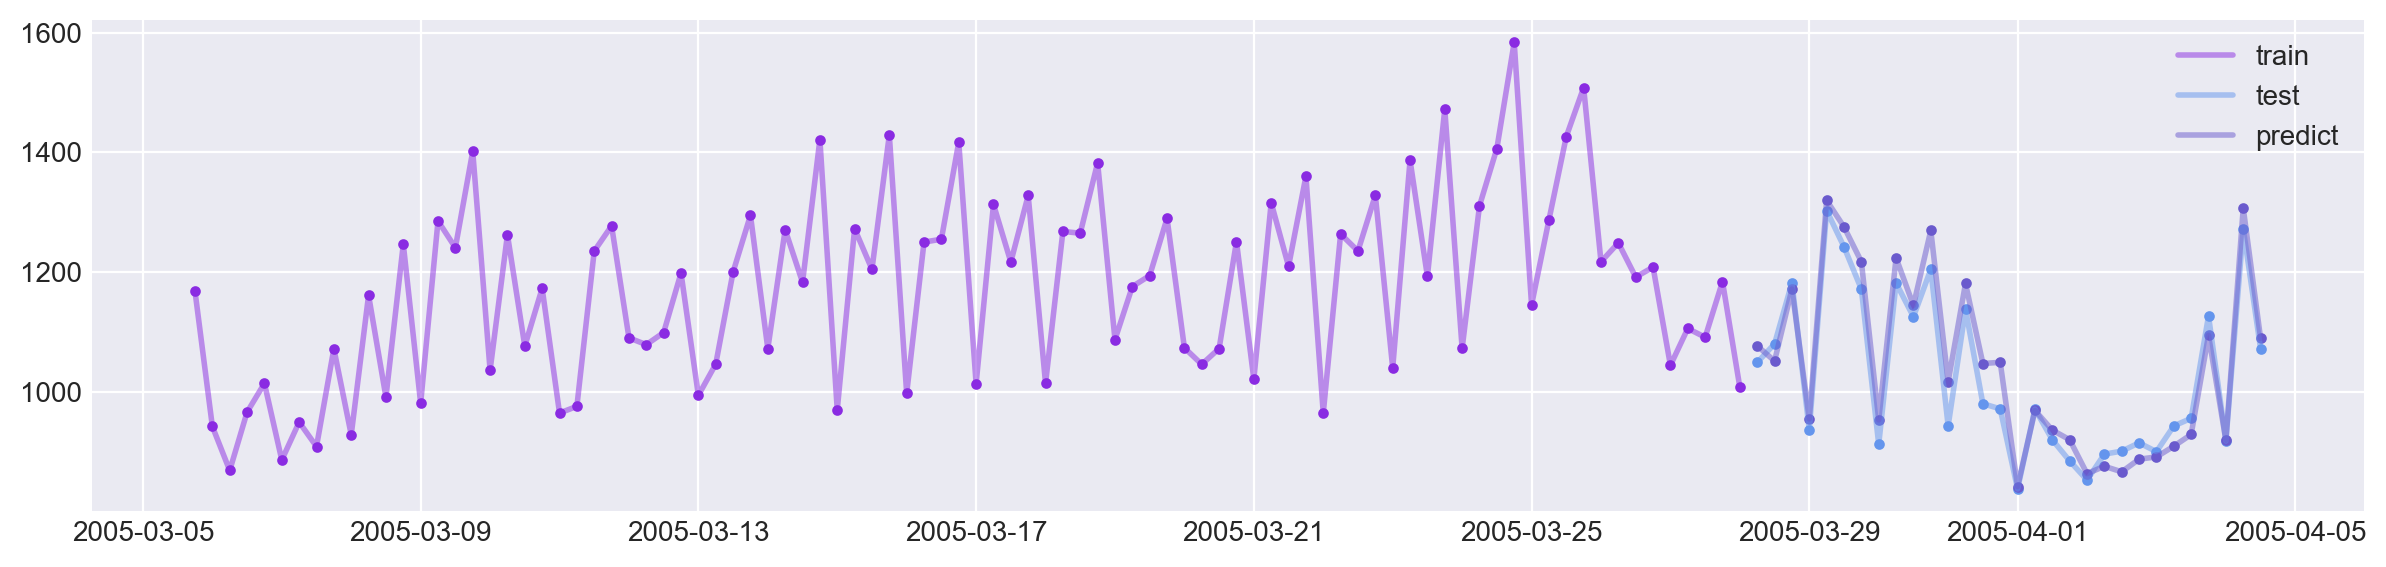

In [24]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [25]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 989.0220597	test: 997.8117921	best: 997.8117921 (0)	total: 178ms	remaining: 2m 58s
1:	learn: 898.3850184	test: 906.7282521	best: 906.7282521 (1)	total: 194ms	remaining: 1m 36s
2:	learn: 819.3014491	test: 826.8616753	best: 826.8616753 (2)	total: 210ms	remaining: 1m 9s
3:	learn: 744.1613442	test: 767.7051747	best: 767.7051747 (3)	total: 227ms	remaining: 56.6s
4:	learn: 674.8702674	test: 694.2624973	best: 694.2624973 (4)	total: 245ms	remaining: 48.8s
5:	learn: 613.3944100	test: 630.3820732	best: 630.3820732 (5)	total: 261ms	remaining: 43.2s
6:	learn: 558.3018521	test: 579.7665239	best: 579.7665239 (6)	total: 276ms	remaining: 39.1s
7:	learn: 507.3721605	test: 531.7940639	best: 531.7940639 (7)	total: 291ms	remaining: 36s
8:	learn: 462.4531213	test: 489.1936836	best: 489.1936836 (8)	total: 301ms	remaining: 33.1s
9:	learn: 420.0824582	test: 447.1566733	best: 447.1566733 (9)	total: 309ms	remaining: 30.6s
10:	learn: 383.2087142	test: 422.0331468	best: 422.0331468 (10)	total: 318ms	rem

97:	learn: 41.9258549	test: 72.9903255	best: 72.9903255 (97)	total: 1.48s	remaining: 13.6s
98:	learn: 41.6257409	test: 72.5592006	best: 72.5592006 (98)	total: 1.5s	remaining: 13.6s
99:	learn: 41.3434229	test: 72.6763352	best: 72.5592006 (98)	total: 1.51s	remaining: 13.6s
100:	learn: 41.2008931	test: 72.6082491	best: 72.5592006 (98)	total: 1.53s	remaining: 13.6s
101:	learn: 40.9531282	test: 72.7453645	best: 72.5592006 (98)	total: 1.54s	remaining: 13.6s
102:	learn: 40.8057101	test: 72.6156709	best: 72.5592006 (98)	total: 1.56s	remaining: 13.6s
103:	learn: 40.5573771	test: 72.3282073	best: 72.3282073 (103)	total: 1.57s	remaining: 13.6s
104:	learn: 40.3617170	test: 72.2577205	best: 72.2577205 (104)	total: 1.58s	remaining: 13.5s
105:	learn: 40.1858185	test: 72.2391724	best: 72.2391724 (105)	total: 1.59s	remaining: 13.4s
106:	learn: 39.9549528	test: 72.3512822	best: 72.2391724 (105)	total: 1.6s	remaining: 13.4s
107:	learn: 39.7591100	test: 72.3344306	best: 72.2391724 (105)	total: 1.62s	remai

189:	learn: 29.6033504	test: 66.6672207	best: 66.5625693 (185)	total: 2.79s	remaining: 11.9s
190:	learn: 29.5176057	test: 66.5170877	best: 66.5170877 (190)	total: 2.81s	remaining: 11.9s
191:	learn: 29.3865855	test: 66.4030114	best: 66.4030114 (191)	total: 2.82s	remaining: 11.9s
192:	learn: 29.2851881	test: 66.3923255	best: 66.3923255 (192)	total: 2.84s	remaining: 11.9s
193:	learn: 29.1932383	test: 66.3726182	best: 66.3726182 (193)	total: 2.85s	remaining: 11.8s
194:	learn: 29.1392150	test: 66.2736219	best: 66.2736219 (194)	total: 2.87s	remaining: 11.8s
195:	learn: 29.0427179	test: 66.3023418	best: 66.2736219 (194)	total: 2.88s	remaining: 11.8s
196:	learn: 28.9543508	test: 66.3074780	best: 66.2736219 (194)	total: 2.9s	remaining: 11.8s
197:	learn: 28.8837374	test: 66.2869199	best: 66.2736219 (194)	total: 2.92s	remaining: 11.8s
198:	learn: 28.8582546	test: 66.2843524	best: 66.2736219 (194)	total: 2.93s	remaining: 11.8s
199:	learn: 28.7683770	test: 66.1692441	best: 66.1692441 (199)	total: 2

284:	learn: 23.3580500	test: 63.9969469	best: 63.9969469 (284)	total: 3.88s	remaining: 9.72s
285:	learn: 23.3053454	test: 63.9544784	best: 63.9544784 (285)	total: 3.89s	remaining: 9.72s
286:	learn: 23.2237405	test: 63.9563460	best: 63.9544784 (285)	total: 3.91s	remaining: 9.71s
287:	learn: 23.1653296	test: 63.8223528	best: 63.8223528 (287)	total: 3.92s	remaining: 9.7s
288:	learn: 23.1018994	test: 63.8290248	best: 63.8223528 (287)	total: 3.94s	remaining: 9.69s
289:	learn: 23.0244387	test: 63.8114358	best: 63.8114358 (289)	total: 3.95s	remaining: 9.67s
290:	learn: 22.9569226	test: 63.8152158	best: 63.8114358 (289)	total: 3.96s	remaining: 9.66s
291:	learn: 22.9032740	test: 63.7849332	best: 63.7849332 (291)	total: 3.98s	remaining: 9.64s
292:	learn: 22.8366537	test: 63.7792015	best: 63.7792015 (292)	total: 3.99s	remaining: 9.62s
293:	learn: 22.7839451	test: 63.8026790	best: 63.7792015 (292)	total: 4s	remaining: 9.6s
294:	learn: 22.7582808	test: 63.8211035	best: 63.7792015 (292)	total: 4.01s

379:	learn: 19.1034148	test: 62.8788837	best: 62.8788837 (379)	total: 5.05s	remaining: 8.24s
380:	learn: 19.0765586	test: 62.8776533	best: 62.8776533 (380)	total: 5.07s	remaining: 8.23s
381:	learn: 19.0460877	test: 62.8292273	best: 62.8292273 (381)	total: 5.08s	remaining: 8.22s
382:	learn: 19.0029428	test: 62.8212404	best: 62.8212404 (382)	total: 5.09s	remaining: 8.21s
383:	learn: 18.9712515	test: 62.7849886	best: 62.7849886 (383)	total: 5.11s	remaining: 8.19s
384:	learn: 18.9115345	test: 62.8134764	best: 62.7849886 (383)	total: 5.11s	remaining: 8.17s
385:	learn: 18.8745158	test: 62.7815592	best: 62.7815592 (385)	total: 5.12s	remaining: 8.15s
386:	learn: 18.8386936	test: 62.7767416	best: 62.7767416 (386)	total: 5.13s	remaining: 8.13s
387:	learn: 18.8011532	test: 62.7919830	best: 62.7767416 (386)	total: 5.15s	remaining: 8.12s
388:	learn: 18.7611527	test: 62.7458084	best: 62.7458084 (388)	total: 5.17s	remaining: 8.11s
389:	learn: 18.7201085	test: 62.7541837	best: 62.7458084 (388)	total: 

474:	learn: 16.0165714	test: 62.1818828	best: 62.1598731 (472)	total: 6.16s	remaining: 6.81s
475:	learn: 15.9807833	test: 62.1500291	best: 62.1500291 (475)	total: 6.2s	remaining: 6.83s
476:	learn: 15.9471848	test: 62.1389395	best: 62.1389395 (476)	total: 6.22s	remaining: 6.82s
477:	learn: 15.9150792	test: 62.1362161	best: 62.1362161 (477)	total: 6.24s	remaining: 6.81s
478:	learn: 15.8906446	test: 62.0825023	best: 62.0825023 (478)	total: 6.25s	remaining: 6.8s
479:	learn: 15.8562335	test: 62.0637475	best: 62.0637475 (479)	total: 6.26s	remaining: 6.79s
480:	learn: 15.8283814	test: 62.1684828	best: 62.0637475 (479)	total: 6.28s	remaining: 6.77s
481:	learn: 15.7908312	test: 62.1347958	best: 62.0637475 (479)	total: 6.29s	remaining: 6.76s
482:	learn: 15.7652190	test: 62.1290577	best: 62.0637475 (479)	total: 6.3s	remaining: 6.74s
483:	learn: 15.7315365	test: 62.1195414	best: 62.0637475 (479)	total: 6.31s	remaining: 6.73s
484:	learn: 15.7053745	test: 62.1121688	best: 62.0637475 (479)	total: 6.3

584:	learn: 13.1144178	test: 61.6458539	best: 61.6088602 (582)	total: 7.68s	remaining: 5.45s
585:	learn: 13.0974898	test: 61.6491086	best: 61.6088602 (582)	total: 7.69s	remaining: 5.43s
586:	learn: 13.0731410	test: 61.6540067	best: 61.6088602 (582)	total: 7.71s	remaining: 5.42s
587:	learn: 13.0631306	test: 61.6629976	best: 61.6088602 (582)	total: 7.72s	remaining: 5.41s
588:	learn: 13.0389766	test: 61.6774612	best: 61.6088602 (582)	total: 7.73s	remaining: 5.39s
589:	learn: 13.0135918	test: 61.6854635	best: 61.6088602 (582)	total: 7.74s	remaining: 5.38s
590:	learn: 12.9977749	test: 61.6946605	best: 61.6088602 (582)	total: 7.75s	remaining: 5.36s
591:	learn: 12.9718595	test: 61.6788068	best: 61.6088602 (582)	total: 7.75s	remaining: 5.34s
592:	learn: 12.9647135	test: 61.6784932	best: 61.6088602 (582)	total: 7.77s	remaining: 5.33s
593:	learn: 12.9411439	test: 61.6764961	best: 61.6088602 (582)	total: 7.79s	remaining: 5.32s
594:	learn: 12.9320421	test: 61.6965153	best: 61.6088602 (582)	total: 

676:	learn: 11.2383624	test: 61.7372541	best: 61.5657458 (641)	total: 8.95s	remaining: 4.27s
677:	learn: 11.2180355	test: 61.7354535	best: 61.5657458 (641)	total: 8.96s	remaining: 4.25s
678:	learn: 11.1964604	test: 61.7212786	best: 61.5657458 (641)	total: 8.98s	remaining: 4.25s
679:	learn: 11.1716412	test: 61.7176763	best: 61.5657458 (641)	total: 9s	remaining: 4.23s
680:	learn: 11.1540071	test: 61.7402801	best: 61.5657458 (641)	total: 9.02s	remaining: 4.22s
681:	learn: 11.1425287	test: 61.7494477	best: 61.5657458 (641)	total: 9.03s	remaining: 4.21s
682:	learn: 11.1189984	test: 61.7274974	best: 61.5657458 (641)	total: 9.05s	remaining: 4.2s
683:	learn: 11.1056630	test: 61.7382975	best: 61.5657458 (641)	total: 9.06s	remaining: 4.19s
684:	learn: 11.0829798	test: 61.7286265	best: 61.5657458 (641)	total: 9.08s	remaining: 4.17s
685:	learn: 11.0640364	test: 61.7455433	best: 61.5657458 (641)	total: 9.09s	remaining: 4.16s
686:	learn: 11.0428076	test: 61.7426251	best: 61.5657458 (641)	total: 9.1s

766:	learn: 9.8051320	test: 61.5357956	best: 61.5357956 (766)	total: 10.2s	remaining: 3.1s
767:	learn: 9.7875348	test: 61.5349373	best: 61.5349373 (767)	total: 10.2s	remaining: 3.09s
768:	learn: 9.7759772	test: 61.5382560	best: 61.5349373 (767)	total: 10.2s	remaining: 3.07s
769:	learn: 9.7587077	test: 61.5390914	best: 61.5349373 (767)	total: 10.3s	remaining: 3.06s
770:	learn: 9.7482737	test: 61.4973117	best: 61.4973117 (770)	total: 10.3s	remaining: 3.05s
771:	learn: 9.7357669	test: 61.4981442	best: 61.4973117 (770)	total: 10.3s	remaining: 3.04s
772:	learn: 9.7215345	test: 61.5094788	best: 61.4973117 (770)	total: 10.3s	remaining: 3.03s
773:	learn: 9.7138922	test: 61.5132348	best: 61.4973117 (770)	total: 10.3s	remaining: 3.01s
774:	learn: 9.7062952	test: 61.5168190	best: 61.4973117 (770)	total: 10.3s	remaining: 3s
775:	learn: 9.6970894	test: 61.5210445	best: 61.4973117 (770)	total: 10.3s	remaining: 2.99s
776:	learn: 9.6932462	test: 61.5198330	best: 61.4973117 (770)	total: 10.4s	remaining

880:	learn: 8.3202376	test: 61.3629569	best: 61.3299156 (872)	total: 11.1s	remaining: 1.5s
881:	learn: 8.3086340	test: 61.3623436	best: 61.3299156 (872)	total: 11.1s	remaining: 1.48s
882:	learn: 8.2923573	test: 61.3489726	best: 61.3299156 (872)	total: 11.1s	remaining: 1.47s
883:	learn: 8.2790481	test: 61.3718869	best: 61.3299156 (872)	total: 11.1s	remaining: 1.46s
884:	learn: 8.2588188	test: 61.3257176	best: 61.3257176 (884)	total: 11.1s	remaining: 1.44s
885:	learn: 8.2407680	test: 61.3237521	best: 61.3237521 (885)	total: 11.1s	remaining: 1.43s
886:	learn: 8.2303573	test: 61.3277699	best: 61.3237521 (885)	total: 11.1s	remaining: 1.42s
887:	learn: 8.2220408	test: 61.3345451	best: 61.3237521 (885)	total: 11.1s	remaining: 1.4s
888:	learn: 8.2092988	test: 61.3094396	best: 61.3094396 (888)	total: 11.1s	remaining: 1.39s
889:	learn: 8.2003294	test: 61.3098778	best: 61.3094396 (888)	total: 11.1s	remaining: 1.38s
890:	learn: 8.1920060	test: 61.3160652	best: 61.3094396 (888)	total: 11.1s	remaini

970:	learn: 7.2992351	test: 61.1241010	best: 61.1091400 (969)	total: 12.1s	remaining: 363ms
971:	learn: 7.2791523	test: 61.1204990	best: 61.1091400 (969)	total: 12.2s	remaining: 350ms
972:	learn: 7.2661856	test: 61.1279974	best: 61.1091400 (969)	total: 12.2s	remaining: 338ms
973:	learn: 7.2605638	test: 61.0960696	best: 61.0960696 (973)	total: 12.2s	remaining: 325ms
974:	learn: 7.2527765	test: 61.0900776	best: 61.0900776 (974)	total: 12.2s	remaining: 313ms
975:	learn: 7.2458242	test: 61.0818335	best: 61.0818335 (975)	total: 12.2s	remaining: 301ms
976:	learn: 7.2399212	test: 61.0708750	best: 61.0708750 (976)	total: 12.2s	remaining: 288ms
977:	learn: 7.2262578	test: 61.0780368	best: 61.0708750 (976)	total: 12.3s	remaining: 276ms
978:	learn: 7.2138897	test: 61.0701777	best: 61.0701777 (978)	total: 12.3s	remaining: 263ms
979:	learn: 7.2013198	test: 61.0725794	best: 61.0701777 (978)	total: 12.3s	remaining: 251ms
980:	learn: 7.1957008	test: 61.0681886	best: 61.0681886 (980)	total: 12.3s	remai

67:	learn: 50.0356195	test: 83.7209965	best: 83.7209965 (67)	total: 640ms	remaining: 8.77s
68:	learn: 49.6612779	test: 83.3111061	best: 83.3111061 (68)	total: 654ms	remaining: 8.83s
69:	learn: 49.3454782	test: 82.8215279	best: 82.8215279 (69)	total: 667ms	remaining: 8.87s
70:	learn: 49.0628276	test: 82.6918316	best: 82.6918316 (70)	total: 675ms	remaining: 8.84s
71:	learn: 48.8277585	test: 82.8483110	best: 82.6918316 (70)	total: 684ms	remaining: 8.81s
72:	learn: 48.5797454	test: 82.4667954	best: 82.4667954 (72)	total: 693ms	remaining: 8.8s
73:	learn: 48.2812498	test: 81.8870081	best: 81.8870081 (73)	total: 713ms	remaining: 8.91s
74:	learn: 48.0669455	test: 81.7691264	best: 81.7691264 (74)	total: 728ms	remaining: 8.97s
75:	learn: 47.7142913	test: 81.8426423	best: 81.7691264 (74)	total: 743ms	remaining: 9.03s
76:	learn: 47.3440474	test: 81.5890098	best: 81.5890098 (76)	total: 758ms	remaining: 9.09s
77:	learn: 46.9973220	test: 81.2650964	best: 81.2650964 (77)	total: 775ms	remaining: 9.15s


169:	learn: 30.8894236	test: 70.7257969	best: 70.5672841 (164)	total: 1.94s	remaining: 9.45s
170:	learn: 30.8080636	test: 70.7174855	best: 70.5672841 (164)	total: 1.95s	remaining: 9.46s
171:	learn: 30.7739326	test: 70.6784285	best: 70.5672841 (164)	total: 1.97s	remaining: 9.46s
172:	learn: 30.6930962	test: 70.5923788	best: 70.5672841 (164)	total: 1.98s	remaining: 9.46s
173:	learn: 30.6111993	test: 70.5397885	best: 70.5397885 (173)	total: 1.99s	remaining: 9.46s
174:	learn: 30.5361026	test: 70.1795192	best: 70.1795192 (174)	total: 2.01s	remaining: 9.46s
175:	learn: 30.4034845	test: 70.2037187	best: 70.1795192 (174)	total: 2.01s	remaining: 9.43s
176:	learn: 30.3121400	test: 70.0097912	best: 70.0097912 (176)	total: 2.02s	remaining: 9.4s
177:	learn: 30.2743060	test: 69.9824975	best: 69.9824975 (177)	total: 2.03s	remaining: 9.38s
178:	learn: 30.1568238	test: 69.9940109	best: 69.9824975 (177)	total: 2.04s	remaining: 9.34s
179:	learn: 30.0410705	test: 69.9772975	best: 69.9772975 (179)	total: 2

271:	learn: 24.1253919	test: 66.9951647	best: 66.9951647 (271)	total: 3.01s	remaining: 8.06s
272:	learn: 24.0764017	test: 67.0432914	best: 66.9951647 (271)	total: 3.02s	remaining: 8.05s
273:	learn: 24.0244598	test: 66.9997554	best: 66.9951647 (271)	total: 3.04s	remaining: 8.04s
274:	learn: 23.9491694	test: 67.0012360	best: 66.9951647 (271)	total: 3.04s	remaining: 8.02s
275:	learn: 23.9032635	test: 67.0284133	best: 66.9951647 (271)	total: 3.05s	remaining: 8.01s
276:	learn: 23.8432057	test: 67.0851662	best: 66.9951647 (271)	total: 3.07s	remaining: 8.02s
277:	learn: 23.8026290	test: 67.0492028	best: 66.9951647 (271)	total: 3.09s	remaining: 8.02s
278:	learn: 23.7260472	test: 67.0985700	best: 66.9951647 (271)	total: 3.1s	remaining: 8.02s
279:	learn: 23.7178993	test: 67.1004193	best: 66.9951647 (271)	total: 3.12s	remaining: 8.01s
280:	learn: 23.6817394	test: 67.1000519	best: 66.9951647 (271)	total: 3.13s	remaining: 8.01s
281:	learn: 23.6357537	test: 67.0771856	best: 66.9951647 (271)	total: 3

367:	learn: 20.2240964	test: 65.7937954	best: 65.7179221 (362)	total: 4.33s	remaining: 7.45s
368:	learn: 20.2195583	test: 65.7861862	best: 65.7179221 (362)	total: 4.35s	remaining: 7.43s
369:	learn: 20.1985790	test: 65.7892457	best: 65.7179221 (362)	total: 4.36s	remaining: 7.42s
370:	learn: 20.1664172	test: 65.8077042	best: 65.7179221 (362)	total: 4.37s	remaining: 7.41s
371:	learn: 20.1250268	test: 65.9069948	best: 65.7179221 (362)	total: 4.38s	remaining: 7.39s
372:	learn: 20.0702557	test: 65.9485073	best: 65.7179221 (362)	total: 4.38s	remaining: 7.37s
373:	learn: 20.0070762	test: 65.9855030	best: 65.7179221 (362)	total: 4.4s	remaining: 7.37s
374:	learn: 19.9810280	test: 65.9727869	best: 65.7179221 (362)	total: 4.41s	remaining: 7.35s
375:	learn: 19.9530368	test: 65.9333077	best: 65.7179221 (362)	total: 4.42s	remaining: 7.33s
376:	learn: 19.9146301	test: 65.8857705	best: 65.7179221 (362)	total: 4.43s	remaining: 7.31s
377:	learn: 19.8852649	test: 65.8927005	best: 65.7179221 (362)	total: 4

464:	learn: 16.9896738	test: 65.1296957	best: 65.1296957 (464)	total: 5.43s	remaining: 6.25s
465:	learn: 16.9515572	test: 65.1689561	best: 65.1296957 (464)	total: 5.45s	remaining: 6.24s
466:	learn: 16.9321115	test: 65.1523659	best: 65.1296957 (464)	total: 5.46s	remaining: 6.24s
467:	learn: 16.8990822	test: 65.1405896	best: 65.1296957 (464)	total: 5.48s	remaining: 6.23s
468:	learn: 16.8763774	test: 65.1396704	best: 65.1296957 (464)	total: 5.5s	remaining: 6.22s
469:	learn: 16.8528392	test: 65.1270328	best: 65.1270328 (469)	total: 5.51s	remaining: 6.21s
470:	learn: 16.8259228	test: 65.1238334	best: 65.1238334 (470)	total: 5.53s	remaining: 6.21s
471:	learn: 16.7899596	test: 65.1130631	best: 65.1130631 (471)	total: 5.55s	remaining: 6.21s
472:	learn: 16.7650067	test: 65.0777072	best: 65.0777072 (472)	total: 5.57s	remaining: 6.21s
473:	learn: 16.7567292	test: 65.0762569	best: 65.0762569 (473)	total: 5.59s	remaining: 6.2s
474:	learn: 16.7205224	test: 65.1232848	best: 65.0762569 (473)	total: 5.

560:	learn: 14.7048734	test: 64.6904735	best: 64.6049280 (552)	total: 6.72s	remaining: 5.26s
561:	learn: 14.6916515	test: 64.6775268	best: 64.6049280 (552)	total: 6.72s	remaining: 5.24s
562:	learn: 14.6753202	test: 64.6710263	best: 64.6049280 (552)	total: 6.72s	remaining: 5.22s
563:	learn: 14.6588793	test: 64.6868879	best: 64.6049280 (552)	total: 6.72s	remaining: 5.2s
564:	learn: 14.6354992	test: 64.6929354	best: 64.6049280 (552)	total: 6.75s	remaining: 5.2s
565:	learn: 14.6200997	test: 64.7044666	best: 64.6049280 (552)	total: 6.76s	remaining: 5.19s
566:	learn: 14.6119270	test: 64.6911277	best: 64.6049280 (552)	total: 6.78s	remaining: 5.18s
567:	learn: 14.5955352	test: 64.6939246	best: 64.6049280 (552)	total: 6.79s	remaining: 5.17s
568:	learn: 14.5550264	test: 64.7235074	best: 64.6049280 (552)	total: 6.81s	remaining: 5.16s
569:	learn: 14.5152446	test: 64.5650412	best: 64.5650412 (569)	total: 6.82s	remaining: 5.14s
570:	learn: 14.4876601	test: 64.5439436	best: 64.5439436 (570)	total: 6.

650:	learn: 12.8257087	test: 64.3110885	best: 64.2152205 (631)	total: 7.58s	remaining: 4.06s
651:	learn: 12.8077864	test: 64.3127681	best: 64.2152205 (631)	total: 7.59s	remaining: 4.05s
652:	learn: 12.7755796	test: 64.3325918	best: 64.2152205 (631)	total: 7.61s	remaining: 4.04s
653:	learn: 12.7612891	test: 64.3308179	best: 64.2152205 (631)	total: 7.62s	remaining: 4.03s
654:	learn: 12.7481286	test: 64.3389251	best: 64.2152205 (631)	total: 7.63s	remaining: 4.02s
655:	learn: 12.7336360	test: 64.3280744	best: 64.2152205 (631)	total: 7.64s	remaining: 4s
656:	learn: 12.7174874	test: 64.3381185	best: 64.2152205 (631)	total: 7.65s	remaining: 3.99s
657:	learn: 12.6995672	test: 64.3383620	best: 64.2152205 (631)	total: 7.66s	remaining: 3.98s
658:	learn: 12.6858866	test: 64.3386773	best: 64.2152205 (631)	total: 7.68s	remaining: 3.98s
659:	learn: 12.6762917	test: 64.3410240	best: 64.2152205 (631)	total: 7.7s	remaining: 3.96s
660:	learn: 12.6450603	test: 64.3450053	best: 64.2152205 (631)	total: 7.71

740:	learn: 11.2429983	test: 64.0913986	best: 64.0740629 (732)	total: 8.67s	remaining: 3.03s
741:	learn: 11.2222582	test: 64.0884738	best: 64.0740629 (732)	total: 8.68s	remaining: 3.02s
742:	learn: 11.2123915	test: 64.0842604	best: 64.0740629 (732)	total: 8.69s	remaining: 3.01s
743:	learn: 11.1994841	test: 64.0788700	best: 64.0740629 (732)	total: 8.7s	remaining: 3s
744:	learn: 11.1731114	test: 64.0507440	best: 64.0507440 (744)	total: 8.71s	remaining: 2.98s
745:	learn: 11.1581997	test: 64.0458873	best: 64.0458873 (745)	total: 8.72s	remaining: 2.97s
746:	learn: 11.1392597	test: 64.0617907	best: 64.0458873 (745)	total: 8.73s	remaining: 2.96s
747:	learn: 11.1278078	test: 64.0638394	best: 64.0458873 (745)	total: 8.75s	remaining: 2.95s
748:	learn: 11.1158140	test: 64.1046602	best: 64.0458873 (745)	total: 8.77s	remaining: 2.94s
749:	learn: 11.0989258	test: 64.1031746	best: 64.0458873 (745)	total: 8.78s	remaining: 2.93s
750:	learn: 11.0871198	test: 64.1247850	best: 64.0458873 (745)	total: 8.79

845:	learn: 9.7355054	test: 64.0371510	best: 64.0140329 (836)	total: 9.97s	remaining: 1.81s
846:	learn: 9.7250384	test: 64.0339198	best: 64.0140329 (836)	total: 9.99s	remaining: 1.8s
847:	learn: 9.7122881	test: 64.0242624	best: 64.0140329 (836)	total: 10s	remaining: 1.79s
848:	learn: 9.7019654	test: 64.0276116	best: 64.0140329 (836)	total: 10s	remaining: 1.78s
849:	learn: 9.6886662	test: 64.0189551	best: 64.0140329 (836)	total: 10s	remaining: 1.77s
850:	learn: 9.6776470	test: 63.9681548	best: 63.9681548 (850)	total: 10s	remaining: 1.76s
851:	learn: 9.6678021	test: 63.9275788	best: 63.9275788 (851)	total: 10.1s	remaining: 1.75s
852:	learn: 9.6592230	test: 63.9332901	best: 63.9275788 (851)	total: 10.1s	remaining: 1.73s
853:	learn: 9.6501571	test: 63.9372228	best: 63.9275788 (851)	total: 10.1s	remaining: 1.72s
854:	learn: 9.6342274	test: 63.9347138	best: 63.9275788 (851)	total: 10.1s	remaining: 1.71s
855:	learn: 9.6256638	test: 63.9156549	best: 63.9156549 (855)	total: 10.1s	remaining: 1.7

944:	learn: 8.5452567	test: 63.8194305	best: 63.7747309 (896)	total: 11.2s	remaining: 655ms
945:	learn: 8.5344172	test: 63.8291546	best: 63.7747309 (896)	total: 11.3s	remaining: 643ms
946:	learn: 8.5289830	test: 63.8273850	best: 63.7747309 (896)	total: 11.3s	remaining: 631ms
947:	learn: 8.5202849	test: 63.8379586	best: 63.7747309 (896)	total: 11.3s	remaining: 619ms
948:	learn: 8.5044332	test: 63.8321963	best: 63.7747309 (896)	total: 11.3s	remaining: 607ms
949:	learn: 8.4992084	test: 63.8326371	best: 63.7747309 (896)	total: 11.3s	remaining: 595ms
950:	learn: 8.4894973	test: 63.8280135	best: 63.7747309 (896)	total: 11.3s	remaining: 583ms
951:	learn: 8.4737465	test: 63.8225680	best: 63.7747309 (896)	total: 11.3s	remaining: 571ms
952:	learn: 8.4661527	test: 63.8221718	best: 63.7747309 (896)	total: 11.3s	remaining: 558ms
953:	learn: 8.4515798	test: 63.8103545	best: 63.7747309 (896)	total: 11.3s	remaining: 547ms
954:	learn: 8.4415238	test: 63.7916973	best: 63.7747309 (896)	total: 11.4s	remai

51:	learn: 51.3793289	test: 90.1472550	best: 90.1472550 (51)	total: 658ms	remaining: 12s
52:	learn: 50.9957969	test: 89.7439232	best: 89.7439232 (52)	total: 672ms	remaining: 12s
53:	learn: 50.3779508	test: 89.6563102	best: 89.6563102 (53)	total: 685ms	remaining: 12s
54:	learn: 49.8286182	test: 89.4130132	best: 89.4130132 (54)	total: 706ms	remaining: 12.1s
55:	learn: 49.5316074	test: 89.1246158	best: 89.1246158 (55)	total: 715ms	remaining: 12.1s
56:	learn: 49.1276721	test: 88.6999390	best: 88.6999390 (56)	total: 723ms	remaining: 12s
57:	learn: 48.8542319	test: 88.6284620	best: 88.6284620 (57)	total: 732ms	remaining: 11.9s
58:	learn: 48.4855344	test: 88.8194373	best: 88.6284620 (57)	total: 749ms	remaining: 11.9s
59:	learn: 48.0798037	test: 88.5635526	best: 88.5635526 (59)	total: 765ms	remaining: 12s
60:	learn: 47.7659173	test: 88.4674195	best: 88.4674195 (60)	total: 780ms	remaining: 12s
61:	learn: 47.4111671	test: 87.5290238	best: 87.5290238 (61)	total: 795ms	remaining: 12s
62:	learn: 47

153:	learn: 28.6254682	test: 83.9574637	best: 83.9350232 (139)	total: 1.96s	remaining: 10.8s
154:	learn: 28.5355264	test: 83.8517522	best: 83.8517522 (154)	total: 1.96s	remaining: 10.7s
155:	learn: 28.4115468	test: 83.7776117	best: 83.7776117 (155)	total: 1.97s	remaining: 10.6s
156:	learn: 28.3300003	test: 83.6975723	best: 83.6975723 (156)	total: 1.97s	remaining: 10.6s
157:	learn: 28.2756595	test: 83.6819074	best: 83.6819074 (157)	total: 1.98s	remaining: 10.5s
158:	learn: 28.1907794	test: 83.6190417	best: 83.6190417 (158)	total: 1.99s	remaining: 10.5s
159:	learn: 28.0578750	test: 83.7133425	best: 83.6190417 (158)	total: 2.01s	remaining: 10.5s
160:	learn: 27.9566763	test: 83.7623539	best: 83.6190417 (158)	total: 2.02s	remaining: 10.5s
161:	learn: 27.8660900	test: 83.7251642	best: 83.6190417 (158)	total: 2.04s	remaining: 10.5s
162:	learn: 27.7875793	test: 83.7153932	best: 83.6190417 (158)	total: 2.05s	remaining: 10.5s
163:	learn: 27.6734229	test: 83.9605998	best: 83.6190417 (158)	total: 

243:	learn: 21.5055713	test: 82.8689181	best: 82.8161350 (226)	total: 3.05s	remaining: 9.46s
244:	learn: 21.4834682	test: 82.9445025	best: 82.8161350 (226)	total: 3.07s	remaining: 9.46s
245:	learn: 21.4183814	test: 83.0596577	best: 82.8161350 (226)	total: 3.08s	remaining: 9.45s
246:	learn: 21.3140417	test: 83.1965512	best: 82.8161350 (226)	total: 3.1s	remaining: 9.45s
247:	learn: 21.2263334	test: 82.9712275	best: 82.8161350 (226)	total: 3.11s	remaining: 9.44s
248:	learn: 21.1551052	test: 82.9162556	best: 82.8161350 (226)	total: 3.13s	remaining: 9.43s
249:	learn: 21.1090246	test: 82.9132331	best: 82.8161350 (226)	total: 3.13s	remaining: 9.41s
250:	learn: 21.0327452	test: 83.0887918	best: 82.8161350 (226)	total: 3.14s	remaining: 9.38s
251:	learn: 20.9824285	test: 83.0619937	best: 82.8161350 (226)	total: 3.15s	remaining: 9.35s
252:	learn: 20.9358617	test: 83.0917236	best: 82.8161350 (226)	total: 3.16s	remaining: 9.34s
253:	learn: 20.8596454	test: 83.0905077	best: 82.8161350 (226)	total: 3

343:	learn: 16.6152207	test: 82.9492717	best: 82.8056513 (313)	total: 4.38s	remaining: 8.36s
344:	learn: 16.5934805	test: 82.9557971	best: 82.8056513 (313)	total: 4.39s	remaining: 8.34s
345:	learn: 16.5536934	test: 82.8638840	best: 82.8056513 (313)	total: 4.4s	remaining: 8.31s
346:	learn: 16.4979526	test: 82.8560245	best: 82.8056513 (313)	total: 4.4s	remaining: 8.29s
347:	learn: 16.4698724	test: 82.8398632	best: 82.8056513 (313)	total: 4.41s	remaining: 8.26s
348:	learn: 16.4474684	test: 82.8371113	best: 82.8056513 (313)	total: 4.41s	remaining: 8.23s
349:	learn: 16.4164168	test: 82.8240652	best: 82.8056513 (313)	total: 4.42s	remaining: 8.2s
350:	learn: 16.3855057	test: 82.8166769	best: 82.8056513 (313)	total: 4.42s	remaining: 8.17s
351:	learn: 16.3546960	test: 82.8249980	best: 82.8056513 (313)	total: 4.45s	remaining: 8.19s
352:	learn: 16.3245645	test: 82.8118871	best: 82.8056513 (313)	total: 4.47s	remaining: 8.19s
353:	learn: 16.2855376	test: 82.8041004	best: 82.8041004 (353)	total: 4.4

444:	learn: 13.6315596	test: 82.3773907	best: 82.3020049 (424)	total: 5.68s	remaining: 7.08s
445:	learn: 13.6087118	test: 82.3657042	best: 82.3020049 (424)	total: 5.68s	remaining: 7.05s
446:	learn: 13.5725770	test: 82.3589768	best: 82.3020049 (424)	total: 5.68s	remaining: 7.03s
447:	learn: 13.5452821	test: 82.3512941	best: 82.3020049 (424)	total: 5.68s	remaining: 7s
448:	learn: 13.5159964	test: 82.3800321	best: 82.3020049 (424)	total: 5.69s	remaining: 6.98s
449:	learn: 13.4899884	test: 82.3616863	best: 82.3020049 (424)	total: 5.69s	remaining: 6.95s
450:	learn: 13.4591612	test: 82.3143585	best: 82.3020049 (424)	total: 5.69s	remaining: 6.93s
451:	learn: 13.4309466	test: 82.3136303	best: 82.3020049 (424)	total: 5.69s	remaining: 6.9s
452:	learn: 13.3970594	test: 82.3556352	best: 82.3020049 (424)	total: 5.69s	remaining: 6.88s
453:	learn: 13.3758316	test: 82.3418599	best: 82.3020049 (424)	total: 5.7s	remaining: 6.85s
454:	learn: 13.3699212	test: 82.3296884	best: 82.3020049 (424)	total: 5.7s	

541:	learn: 11.4314400	test: 82.1147600	best: 82.0868995 (514)	total: 6.76s	remaining: 5.71s
542:	learn: 11.4130509	test: 82.0902567	best: 82.0868995 (514)	total: 6.76s	remaining: 5.69s
543:	learn: 11.3893727	test: 82.0953441	best: 82.0868995 (514)	total: 6.77s	remaining: 5.67s
544:	learn: 11.3712661	test: 82.0843552	best: 82.0843552 (544)	total: 6.77s	remaining: 5.65s
545:	learn: 11.3448792	test: 82.0899108	best: 82.0843552 (544)	total: 6.77s	remaining: 5.63s
546:	learn: 11.3274276	test: 82.1049041	best: 82.0843552 (544)	total: 6.77s	remaining: 5.61s
547:	learn: 11.2960549	test: 82.0937611	best: 82.0843552 (544)	total: 6.77s	remaining: 5.59s
548:	learn: 11.2701015	test: 82.1029354	best: 82.0843552 (544)	total: 6.78s	remaining: 5.57s
549:	learn: 11.2425771	test: 82.1158514	best: 82.0843552 (544)	total: 6.79s	remaining: 5.55s
550:	learn: 11.2293150	test: 82.1083488	best: 82.0843552 (544)	total: 6.8s	remaining: 5.54s
551:	learn: 11.2021574	test: 82.0793518	best: 82.0793518 (551)	total: 6

639:	learn: 9.6823224	test: 82.0930025	best: 81.9995103 (558)	total: 7.86s	remaining: 4.42s
640:	learn: 9.6698911	test: 82.1026250	best: 81.9995103 (558)	total: 7.87s	remaining: 4.41s
641:	learn: 9.6465480	test: 82.1127803	best: 81.9995103 (558)	total: 7.88s	remaining: 4.4s
642:	learn: 9.6297127	test: 82.1176582	best: 81.9995103 (558)	total: 7.9s	remaining: 4.38s
643:	learn: 9.6185988	test: 82.1261921	best: 81.9995103 (558)	total: 7.91s	remaining: 4.37s
644:	learn: 9.6127361	test: 82.1275660	best: 81.9995103 (558)	total: 7.92s	remaining: 4.36s
645:	learn: 9.5944150	test: 82.1266438	best: 81.9995103 (558)	total: 7.93s	remaining: 4.34s
646:	learn: 9.5902345	test: 82.1247184	best: 81.9995103 (558)	total: 7.93s	remaining: 4.33s
647:	learn: 9.5683240	test: 82.1416411	best: 81.9995103 (558)	total: 7.94s	remaining: 4.31s
648:	learn: 9.5540797	test: 82.1408316	best: 81.9995103 (558)	total: 7.95s	remaining: 4.3s
649:	learn: 9.5516973	test: 82.1404530	best: 81.9995103 (558)	total: 7.96s	remainin

740:	learn: 8.1963373	test: 82.0723194	best: 81.9995103 (558)	total: 9.17s	remaining: 3.21s
741:	learn: 8.1862482	test: 82.0666180	best: 81.9995103 (558)	total: 9.18s	remaining: 3.19s
742:	learn: 8.1789920	test: 82.0592866	best: 81.9995103 (558)	total: 9.22s	remaining: 3.19s
743:	learn: 8.1676282	test: 82.0560219	best: 81.9995103 (558)	total: 9.23s	remaining: 3.17s
744:	learn: 8.1614033	test: 82.0462139	best: 81.9995103 (558)	total: 9.24s	remaining: 3.16s
745:	learn: 8.1513302	test: 82.0389293	best: 81.9995103 (558)	total: 9.24s	remaining: 3.15s
746:	learn: 8.1322799	test: 82.0420230	best: 81.9995103 (558)	total: 9.26s	remaining: 3.14s
747:	learn: 8.1177965	test: 82.0634136	best: 81.9995103 (558)	total: 9.28s	remaining: 3.13s
748:	learn: 8.1043327	test: 82.0753694	best: 81.9995103 (558)	total: 9.29s	remaining: 3.11s
749:	learn: 8.0949169	test: 82.0733632	best: 81.9995103 (558)	total: 9.31s	remaining: 3.1s
750:	learn: 8.0802155	test: 82.0631380	best: 81.9995103 (558)	total: 9.32s	remain

839:	learn: 6.9889053	test: 82.4036200	best: 81.9114603 (764)	total: 10.5s	remaining: 2s
840:	learn: 6.9750820	test: 82.3938205	best: 81.9114603 (764)	total: 10.5s	remaining: 1.98s
841:	learn: 6.9665089	test: 82.3844548	best: 81.9114603 (764)	total: 10.5s	remaining: 1.97s
842:	learn: 6.9539580	test: 82.3769480	best: 81.9114603 (764)	total: 10.5s	remaining: 1.96s
843:	learn: 6.9437953	test: 82.3716942	best: 81.9114603 (764)	total: 10.5s	remaining: 1.95s
844:	learn: 6.9315947	test: 82.3582719	best: 81.9114603 (764)	total: 10.5s	remaining: 1.93s
845:	learn: 6.9281615	test: 82.3511802	best: 81.9114603 (764)	total: 10.6s	remaining: 1.92s
846:	learn: 6.9198605	test: 82.3432430	best: 81.9114603 (764)	total: 10.6s	remaining: 1.91s
847:	learn: 6.9143245	test: 82.3421389	best: 81.9114603 (764)	total: 10.6s	remaining: 1.9s
848:	learn: 6.9043498	test: 82.3455234	best: 81.9114603 (764)	total: 10.6s	remaining: 1.88s
849:	learn: 6.8950917	test: 82.3481826	best: 81.9114603 (764)	total: 10.6s	remaining

936:	learn: 6.0397143	test: 82.6057838	best: 81.9114603 (764)	total: 11.6s	remaining: 777ms
937:	learn: 6.0351743	test: 82.6053412	best: 81.9114603 (764)	total: 11.6s	remaining: 766ms
938:	learn: 6.0266447	test: 82.5893671	best: 81.9114603 (764)	total: 11.6s	remaining: 754ms
939:	learn: 6.0157372	test: 82.5873735	best: 81.9114603 (764)	total: 11.6s	remaining: 742ms
940:	learn: 6.0022591	test: 82.5827525	best: 81.9114603 (764)	total: 11.6s	remaining: 729ms
941:	learn: 5.9868003	test: 82.5841683	best: 81.9114603 (764)	total: 11.6s	remaining: 717ms
942:	learn: 5.9728104	test: 82.6213070	best: 81.9114603 (764)	total: 11.7s	remaining: 705ms
943:	learn: 5.9615778	test: 82.6165541	best: 81.9114603 (764)	total: 11.7s	remaining: 693ms
944:	learn: 5.9575019	test: 82.6174807	best: 81.9114603 (764)	total: 11.7s	remaining: 681ms
945:	learn: 5.9473272	test: 82.6166591	best: 81.9114603 (764)	total: 11.7s	remaining: 668ms
946:	learn: 5.9374663	test: 82.6106902	best: 81.9114603 (764)	total: 11.7s	remai

33:	learn: 80.0173445	test: 78.7698721	best: 78.7698721 (33)	total: 375ms	remaining: 10.6s
34:	learn: 77.2681743	test: 78.2368866	best: 78.2368866 (34)	total: 378ms	remaining: 10.4s
35:	learn: 74.8931606	test: 76.8417925	best: 76.8417925 (35)	total: 382ms	remaining: 10.2s
36:	learn: 72.9211718	test: 76.0827871	best: 76.0827871 (36)	total: 385ms	remaining: 10s
37:	learn: 70.9939538	test: 74.9839081	best: 74.9839081 (37)	total: 394ms	remaining: 9.97s
38:	learn: 69.2557705	test: 74.3132296	best: 74.3132296 (38)	total: 404ms	remaining: 9.94s
39:	learn: 68.0580166	test: 73.8759953	best: 73.8759953 (39)	total: 411ms	remaining: 9.86s
40:	learn: 66.8398166	test: 73.1481295	best: 73.1481295 (40)	total: 418ms	remaining: 9.77s
41:	learn: 65.3299938	test: 72.3050740	best: 72.3050740 (41)	total: 425ms	remaining: 9.69s
42:	learn: 64.2089710	test: 72.0705891	best: 72.0705891 (42)	total: 431ms	remaining: 9.6s
43:	learn: 63.1312539	test: 71.4468786	best: 71.4468786 (43)	total: 438ms	remaining: 9.52s
44

131:	learn: 35.0184570	test: 58.1491126	best: 58.1491126 (131)	total: 1.45s	remaining: 9.53s
132:	learn: 34.8467171	test: 58.1971891	best: 58.1491126 (131)	total: 1.46s	remaining: 9.52s
133:	learn: 34.7197145	test: 58.1087961	best: 58.1087961 (133)	total: 1.47s	remaining: 9.51s
134:	learn: 34.5512106	test: 57.9227461	best: 57.9227461 (134)	total: 1.48s	remaining: 9.5s
135:	learn: 34.4183974	test: 57.8340994	best: 57.8340994 (135)	total: 1.49s	remaining: 9.48s
136:	learn: 34.2639725	test: 57.8835835	best: 57.8340994 (135)	total: 1.5s	remaining: 9.45s
137:	learn: 34.1167214	test: 57.6776181	best: 57.6776181 (137)	total: 1.51s	remaining: 9.41s
138:	learn: 33.9460122	test: 57.5304632	best: 57.5304632 (138)	total: 1.51s	remaining: 9.39s
139:	learn: 33.7572079	test: 57.5611335	best: 57.5304632 (138)	total: 1.53s	remaining: 9.4s
140:	learn: 33.6030438	test: 57.4375794	best: 57.4375794 (140)	total: 1.55s	remaining: 9.42s
141:	learn: 33.4916564	test: 57.3817084	best: 57.3817084 (141)	total: 1.5

236:	learn: 24.0514533	test: 54.6766055	best: 54.6291802 (234)	total: 2.76s	remaining: 8.88s
237:	learn: 23.9745377	test: 54.4412248	best: 54.4412248 (237)	total: 2.77s	remaining: 8.87s
238:	learn: 23.9174633	test: 54.3973523	best: 54.3973523 (238)	total: 2.78s	remaining: 8.86s
239:	learn: 23.8876310	test: 54.4095519	best: 54.3973523 (238)	total: 2.79s	remaining: 8.85s
240:	learn: 23.8257314	test: 54.3986219	best: 54.3973523 (238)	total: 2.81s	remaining: 8.84s
241:	learn: 23.7590603	test: 54.3520139	best: 54.3520139 (241)	total: 2.81s	remaining: 8.81s
242:	learn: 23.6792243	test: 54.2798277	best: 54.2798277 (242)	total: 2.82s	remaining: 8.79s
243:	learn: 23.5973631	test: 54.3276631	best: 54.2798277 (242)	total: 2.83s	remaining: 8.77s
244:	learn: 23.5201525	test: 54.3388503	best: 54.2798277 (242)	total: 2.85s	remaining: 8.79s
245:	learn: 23.4659187	test: 54.3261208	best: 54.2798277 (242)	total: 2.87s	remaining: 8.79s
246:	learn: 23.3944901	test: 54.3294664	best: 54.2798277 (242)	total: 

328:	learn: 18.7420628	test: 52.6724155	best: 52.6724155 (328)	total: 3.85s	remaining: 7.86s
329:	learn: 18.6989455	test: 52.6971917	best: 52.6724155 (328)	total: 3.86s	remaining: 7.84s
330:	learn: 18.6326033	test: 52.6993324	best: 52.6724155 (328)	total: 3.87s	remaining: 7.82s
331:	learn: 18.6048199	test: 52.7207131	best: 52.6724155 (328)	total: 3.88s	remaining: 7.8s
332:	learn: 18.5576427	test: 52.6850452	best: 52.6724155 (328)	total: 3.88s	remaining: 7.78s
333:	learn: 18.5075498	test: 52.6531434	best: 52.6531434 (333)	total: 3.89s	remaining: 7.76s
334:	learn: 18.4708288	test: 52.6545306	best: 52.6531434 (333)	total: 3.9s	remaining: 7.74s
335:	learn: 18.4251573	test: 52.4061635	best: 52.4061635 (335)	total: 3.91s	remaining: 7.72s
336:	learn: 18.3932287	test: 52.4151638	best: 52.4061635 (335)	total: 3.91s	remaining: 7.69s
337:	learn: 18.3530175	test: 52.4181914	best: 52.4061635 (335)	total: 3.92s	remaining: 7.67s
338:	learn: 18.3101746	test: 52.4524274	best: 52.4061635 (335)	total: 3.

427:	learn: 15.0103381	test: 51.4894729	best: 51.4894729 (427)	total: 4.91s	remaining: 6.57s
428:	learn: 14.9739458	test: 51.4944522	best: 51.4894729 (427)	total: 4.93s	remaining: 6.56s
429:	learn: 14.9504890	test: 51.5036079	best: 51.4894729 (427)	total: 4.95s	remaining: 6.55s
430:	learn: 14.9335084	test: 51.5006579	best: 51.4894729 (427)	total: 4.96s	remaining: 6.54s
431:	learn: 14.8915849	test: 51.4936320	best: 51.4894729 (427)	total: 4.97s	remaining: 6.54s
432:	learn: 14.8624489	test: 51.4717431	best: 51.4717431 (432)	total: 4.98s	remaining: 6.53s
433:	learn: 14.8457743	test: 51.4891369	best: 51.4717431 (432)	total: 4.99s	remaining: 6.51s
434:	learn: 14.8245840	test: 51.4840640	best: 51.4717431 (432)	total: 5s	remaining: 6.49s
435:	learn: 14.7814383	test: 51.4981392	best: 51.4717431 (432)	total: 5s	remaining: 6.47s
436:	learn: 14.7390170	test: 51.4752046	best: 51.4717431 (432)	total: 5.01s	remaining: 6.45s
437:	learn: 14.7175487	test: 51.4648566	best: 51.4648566 (437)	total: 5.01s	

555:	learn: 11.8029279	test: 51.1661392	best: 51.1243851 (516)	total: 5.52s	remaining: 4.41s
556:	learn: 11.7924268	test: 51.1656765	best: 51.1243851 (516)	total: 5.52s	remaining: 4.39s
557:	learn: 11.7581334	test: 51.1600200	best: 51.1243851 (516)	total: 5.53s	remaining: 4.38s
558:	learn: 11.7466783	test: 51.1978259	best: 51.1243851 (516)	total: 5.53s	remaining: 4.36s
559:	learn: 11.7345371	test: 51.2586734	best: 51.1243851 (516)	total: 5.53s	remaining: 4.34s
560:	learn: 11.7152393	test: 51.2610307	best: 51.1243851 (516)	total: 5.53s	remaining: 4.33s
561:	learn: 11.6919024	test: 51.2580776	best: 51.1243851 (516)	total: 5.54s	remaining: 4.32s
562:	learn: 11.6821430	test: 51.2558480	best: 51.1243851 (516)	total: 5.54s	remaining: 4.3s
563:	learn: 11.6698749	test: 51.2495086	best: 51.1243851 (516)	total: 5.55s	remaining: 4.29s
564:	learn: 11.6582991	test: 51.2370685	best: 51.1243851 (516)	total: 5.56s	remaining: 4.28s
565:	learn: 11.6556165	test: 51.2503859	best: 51.1243851 (516)	total: 5

674:	learn: 9.6450590	test: 51.0001604	best: 50.9638726 (666)	total: 6.14s	remaining: 2.95s
675:	learn: 9.6265686	test: 50.9975678	best: 50.9638726 (666)	total: 6.14s	remaining: 2.94s
676:	learn: 9.6062182	test: 50.9797961	best: 50.9638726 (666)	total: 6.14s	remaining: 2.93s
677:	learn: 9.5944617	test: 50.9772448	best: 50.9638726 (666)	total: 6.14s	remaining: 2.92s
678:	learn: 9.5756766	test: 50.9655671	best: 50.9638726 (666)	total: 6.15s	remaining: 2.9s
679:	learn: 9.5546152	test: 50.9504529	best: 50.9504529 (679)	total: 6.15s	remaining: 2.89s
680:	learn: 9.5306072	test: 50.9700313	best: 50.9504529 (679)	total: 6.15s	remaining: 2.88s
681:	learn: 9.5224989	test: 50.9742092	best: 50.9504529 (679)	total: 6.16s	remaining: 2.87s
682:	learn: 9.5073244	test: 50.9699981	best: 50.9504529 (679)	total: 6.17s	remaining: 2.86s
683:	learn: 9.4867837	test: 50.9770120	best: 50.9504529 (679)	total: 6.17s	remaining: 2.85s
684:	learn: 9.4742707	test: 50.9856476	best: 50.9504529 (679)	total: 6.17s	remain

793:	learn: 7.9121722	test: 50.7149545	best: 50.7064761 (787)	total: 6.75s	remaining: 1.75s
794:	learn: 7.8993697	test: 50.7133961	best: 50.7064761 (787)	total: 6.75s	remaining: 1.74s
795:	learn: 7.8846638	test: 50.7120170	best: 50.7064761 (787)	total: 6.75s	remaining: 1.73s
796:	learn: 7.8727163	test: 50.7062178	best: 50.7062178 (796)	total: 6.75s	remaining: 1.72s
797:	learn: 7.8586437	test: 50.7072635	best: 50.7062178 (796)	total: 6.75s	remaining: 1.71s
798:	learn: 7.8404883	test: 50.7193672	best: 50.7062178 (796)	total: 6.75s	remaining: 1.7s
799:	learn: 7.8274808	test: 50.7136944	best: 50.7062178 (796)	total: 6.76s	remaining: 1.69s
800:	learn: 7.8107888	test: 50.7204281	best: 50.7062178 (796)	total: 6.76s	remaining: 1.68s
801:	learn: 7.8030268	test: 50.7190481	best: 50.7062178 (796)	total: 6.76s	remaining: 1.67s
802:	learn: 7.7873516	test: 50.7107663	best: 50.7062178 (796)	total: 6.76s	remaining: 1.66s
803:	learn: 7.7751316	test: 50.6974050	best: 50.6974050 (803)	total: 6.77s	remain

884:	learn: 6.8398399	test: 50.7428713	best: 50.6974050 (803)	total: 7.15s	remaining: 930ms
885:	learn: 6.8389871	test: 50.7431338	best: 50.6974050 (803)	total: 7.16s	remaining: 921ms
886:	learn: 6.8303592	test: 50.7466513	best: 50.6974050 (803)	total: 7.16s	remaining: 912ms
887:	learn: 6.8194101	test: 50.7531966	best: 50.6974050 (803)	total: 7.16s	remaining: 903ms
888:	learn: 6.8070396	test: 50.7518910	best: 50.6974050 (803)	total: 7.16s	remaining: 894ms
889:	learn: 6.7971901	test: 50.7462782	best: 50.6974050 (803)	total: 7.16s	remaining: 885ms
890:	learn: 6.7839779	test: 50.7410274	best: 50.6974050 (803)	total: 7.16s	remaining: 876ms
891:	learn: 6.7812574	test: 50.7381939	best: 50.6974050 (803)	total: 7.16s	remaining: 867ms
892:	learn: 6.7712031	test: 50.7397924	best: 50.6974050 (803)	total: 7.17s	remaining: 859ms
893:	learn: 6.7617187	test: 50.7372813	best: 50.6974050 (803)	total: 7.17s	remaining: 850ms
894:	learn: 6.7465485	test: 50.7223094	best: 50.6974050 (803)	total: 7.18s	remai

987:	learn: 5.8137704	test: 50.6412050	best: 50.6292222 (983)	total: 7.56s	remaining: 91.9ms
988:	learn: 5.8111646	test: 50.6358946	best: 50.6292222 (983)	total: 7.57s	remaining: 84.2ms
989:	learn: 5.7958204	test: 50.6373212	best: 50.6292222 (983)	total: 7.57s	remaining: 76.5ms
990:	learn: 5.7865842	test: 50.6526386	best: 50.6292222 (983)	total: 7.58s	remaining: 68.8ms
991:	learn: 5.7710436	test: 50.6579035	best: 50.6292222 (983)	total: 7.58s	remaining: 61.1ms
992:	learn: 5.7617439	test: 50.6566925	best: 50.6292222 (983)	total: 7.59s	remaining: 53.5ms
993:	learn: 5.7560966	test: 50.6563971	best: 50.6292222 (983)	total: 7.59s	remaining: 45.8ms
994:	learn: 5.7454112	test: 50.6517830	best: 50.6292222 (983)	total: 7.6s	remaining: 38.2ms
995:	learn: 5.7392676	test: 50.6528675	best: 50.6292222 (983)	total: 7.6s	remaining: 30.5ms
996:	learn: 5.7308241	test: 50.6407410	best: 50.6292222 (983)	total: 7.61s	remaining: 22.9ms
997:	learn: 5.7209113	test: 50.6402774	best: 50.6292222 (983)	total: 7.6

120:	learn: 33.4964349	test: 117.2984571	best: 116.5468441 (98)	total: 515ms	remaining: 3.74s
121:	learn: 33.4063086	test: 117.2530054	best: 116.5468441 (98)	total: 517ms	remaining: 3.72s
122:	learn: 33.2516953	test: 116.7814190	best: 116.5468441 (98)	total: 519ms	remaining: 3.7s
123:	learn: 33.1116989	test: 116.7329423	best: 116.5468441 (98)	total: 521ms	remaining: 3.68s
124:	learn: 32.9491979	test: 116.4594081	best: 116.4594081 (124)	total: 522ms	remaining: 3.65s
125:	learn: 32.8018877	test: 115.6446005	best: 115.6446005 (125)	total: 524ms	remaining: 3.63s
126:	learn: 32.7142422	test: 115.0850835	best: 115.0850835 (126)	total: 528ms	remaining: 3.63s
127:	learn: 32.5757655	test: 115.0000306	best: 115.0000306 (127)	total: 534ms	remaining: 3.64s
128:	learn: 32.3802022	test: 115.0534984	best: 115.0000306 (127)	total: 538ms	remaining: 3.63s
129:	learn: 32.2852394	test: 115.2391415	best: 115.0000306 (127)	total: 543ms	remaining: 3.63s
130:	learn: 32.2133267	test: 115.3282085	best: 115.0000

210:	learn: 24.6030428	test: 109.6891097	best: 109.6124507 (209)	total: 1.37s	remaining: 5.14s
211:	learn: 24.5586233	test: 109.6870691	best: 109.6124507 (209)	total: 1.38s	remaining: 5.14s
212:	learn: 24.4629775	test: 109.6922316	best: 109.6124507 (209)	total: 1.39s	remaining: 5.15s
213:	learn: 24.3904280	test: 109.7476304	best: 109.6124507 (209)	total: 1.41s	remaining: 5.19s
214:	learn: 24.3126946	test: 109.6701574	best: 109.6124507 (209)	total: 1.43s	remaining: 5.21s
215:	learn: 24.2330030	test: 109.6537077	best: 109.6124507 (209)	total: 1.43s	remaining: 5.19s
216:	learn: 24.1445076	test: 109.4777122	best: 109.4777122 (216)	total: 1.44s	remaining: 5.18s
217:	learn: 24.1120552	test: 109.3974861	best: 109.3974861 (217)	total: 1.44s	remaining: 5.18s
218:	learn: 24.0177712	test: 109.2100309	best: 109.2100309 (218)	total: 1.45s	remaining: 5.17s
219:	learn: 23.9461089	test: 109.1539114	best: 109.1539114 (219)	total: 1.46s	remaining: 5.16s
220:	learn: 23.8544589	test: 109.0470956	best: 109

300:	learn: 19.0707706	test: 105.9639926	best: 105.9639926 (300)	total: 1.78s	remaining: 4.14s
301:	learn: 19.0119932	test: 105.9417035	best: 105.9417035 (301)	total: 1.78s	remaining: 4.13s
302:	learn: 18.9694554	test: 105.8829689	best: 105.8829689 (302)	total: 1.79s	remaining: 4.11s
303:	learn: 18.9281727	test: 105.8779165	best: 105.8779165 (303)	total: 1.79s	remaining: 4.09s
304:	learn: 18.8900314	test: 105.8728550	best: 105.8728550 (304)	total: 1.79s	remaining: 4.08s
305:	learn: 18.8288726	test: 105.8555420	best: 105.8555420 (305)	total: 1.79s	remaining: 4.06s
306:	learn: 18.7983869	test: 105.9303684	best: 105.8555420 (305)	total: 1.79s	remaining: 4.04s
307:	learn: 18.7563698	test: 105.9734877	best: 105.8555420 (305)	total: 1.79s	remaining: 4.03s
308:	learn: 18.7322049	test: 105.9681480	best: 105.8555420 (305)	total: 1.79s	remaining: 4.01s
309:	learn: 18.6823337	test: 105.9616476	best: 105.8555420 (305)	total: 1.79s	remaining: 4s
310:	learn: 18.6309116	test: 106.0839572	best: 105.85

410:	learn: 14.8511053	test: 104.7696520	best: 104.7660586 (409)	total: 2.19s	remaining: 3.14s
411:	learn: 14.8435234	test: 104.6953171	best: 104.6953171 (411)	total: 2.19s	remaining: 3.13s
412:	learn: 14.8148698	test: 104.6991125	best: 104.6953171 (411)	total: 2.19s	remaining: 3.12s
413:	learn: 14.7772126	test: 104.6280895	best: 104.6280895 (413)	total: 2.19s	remaining: 3.1s
414:	learn: 14.7324072	test: 104.6627926	best: 104.6280895 (413)	total: 2.19s	remaining: 3.09s
415:	learn: 14.7056911	test: 104.6593315	best: 104.6280895 (413)	total: 2.2s	remaining: 3.08s
416:	learn: 14.6845315	test: 104.6516845	best: 104.6280895 (413)	total: 2.2s	remaining: 3.07s
417:	learn: 14.6519635	test: 104.6321346	best: 104.6280895 (413)	total: 2.2s	remaining: 3.06s
418:	learn: 14.6195446	test: 104.5800382	best: 104.5800382 (418)	total: 2.2s	remaining: 3.05s
419:	learn: 14.6133434	test: 104.5629235	best: 104.5629235 (419)	total: 2.2s	remaining: 3.04s
420:	learn: 14.5774184	test: 104.5452233	best: 104.54522

536:	learn: 11.7712105	test: 104.4952500	best: 104.2902954 (459)	total: 2.59s	remaining: 2.24s
537:	learn: 11.7384525	test: 104.4687947	best: 104.2902954 (459)	total: 2.6s	remaining: 2.23s
538:	learn: 11.7239379	test: 104.4635119	best: 104.2902954 (459)	total: 2.6s	remaining: 2.22s
539:	learn: 11.7202021	test: 104.4573415	best: 104.2902954 (459)	total: 2.6s	remaining: 2.21s
540:	learn: 11.7011279	test: 104.4904712	best: 104.2902954 (459)	total: 2.6s	remaining: 2.21s
541:	learn: 11.6788596	test: 104.4947600	best: 104.2902954 (459)	total: 2.6s	remaining: 2.2s
542:	learn: 11.6731368	test: 104.4803344	best: 104.2902954 (459)	total: 2.6s	remaining: 2.19s
543:	learn: 11.6461946	test: 104.4720708	best: 104.2902954 (459)	total: 2.6s	remaining: 2.18s
544:	learn: 11.6277579	test: 104.4565123	best: 104.2902954 (459)	total: 2.6s	remaining: 2.17s
545:	learn: 11.6005825	test: 104.4567040	best: 104.2902954 (459)	total: 2.6s	remaining: 2.17s
546:	learn: 11.5721503	test: 104.4698801	best: 104.2902954 (

636:	learn: 9.8141771	test: 103.8257174	best: 103.8159812 (627)	total: 3s	remaining: 1.71s
637:	learn: 9.7971211	test: 103.8276641	best: 103.8159812 (627)	total: 3s	remaining: 1.7s
638:	learn: 9.7761406	test: 103.8055495	best: 103.8055495 (638)	total: 3s	remaining: 1.7s
639:	learn: 9.7559656	test: 103.7521989	best: 103.7521989 (639)	total: 3s	remaining: 1.69s
640:	learn: 9.7401356	test: 103.7449985	best: 103.7449985 (640)	total: 3.01s	remaining: 1.68s
641:	learn: 9.7281370	test: 103.7385807	best: 103.7385807 (641)	total: 3.01s	remaining: 1.68s
642:	learn: 9.7046591	test: 103.7417186	best: 103.7385807 (641)	total: 3.01s	remaining: 1.67s
643:	learn: 9.6950020	test: 103.7217312	best: 103.7217312 (643)	total: 3.01s	remaining: 1.67s
644:	learn: 9.6877363	test: 103.7171347	best: 103.7171347 (644)	total: 3.01s	remaining: 1.66s
645:	learn: 9.6719265	test: 103.7385753	best: 103.7171347 (644)	total: 3.02s	remaining: 1.65s
646:	learn: 9.6593182	test: 103.7332188	best: 103.7171347 (644)	total: 3.0

746:	learn: 8.1396197	test: 103.3827924	best: 103.3498487 (744)	total: 3.42s	remaining: 1.16s
747:	learn: 8.1281019	test: 103.3984761	best: 103.3498487 (744)	total: 3.42s	remaining: 1.15s
748:	learn: 8.1106646	test: 103.3974239	best: 103.3498487 (744)	total: 3.42s	remaining: 1.15s
749:	learn: 8.0936081	test: 103.3977368	best: 103.3498487 (744)	total: 3.42s	remaining: 1.14s
750:	learn: 8.0866262	test: 103.3924570	best: 103.3498487 (744)	total: 3.42s	remaining: 1.13s
751:	learn: 8.0739579	test: 103.3899621	best: 103.3498487 (744)	total: 3.43s	remaining: 1.13s
752:	learn: 8.0730445	test: 103.3649266	best: 103.3498487 (744)	total: 3.43s	remaining: 1.13s
753:	learn: 8.0589716	test: 103.3481137	best: 103.3481137 (753)	total: 3.44s	remaining: 1.12s
754:	learn: 8.0405274	test: 103.3453814	best: 103.3453814 (754)	total: 3.44s	remaining: 1.12s
755:	learn: 8.0282939	test: 103.3495799	best: 103.3453814 (754)	total: 3.44s	remaining: 1.11s
756:	learn: 8.0180185	test: 103.3434932	best: 103.3434932 (7

835:	learn: 7.0490840	test: 103.1112441	best: 103.0883389 (830)	total: 4.06s	remaining: 796ms
836:	learn: 7.0383034	test: 103.1261854	best: 103.0883389 (830)	total: 4.07s	remaining: 793ms
837:	learn: 7.0268503	test: 103.1109600	best: 103.0883389 (830)	total: 4.08s	remaining: 789ms
838:	learn: 7.0127702	test: 103.1092603	best: 103.0883389 (830)	total: 4.09s	remaining: 786ms
839:	learn: 7.0027883	test: 103.1121099	best: 103.0883389 (830)	total: 4.1s	remaining: 781ms
840:	learn: 6.9968417	test: 103.1117537	best: 103.0883389 (830)	total: 4.11s	remaining: 777ms
841:	learn: 6.9927653	test: 103.1104869	best: 103.0883389 (830)	total: 4.12s	remaining: 773ms
842:	learn: 6.9857366	test: 103.1081943	best: 103.0883389 (830)	total: 4.14s	remaining: 771ms
843:	learn: 6.9794907	test: 103.0982122	best: 103.0883389 (830)	total: 4.15s	remaining: 768ms
844:	learn: 6.9649039	test: 103.1019202	best: 103.0883389 (830)	total: 4.17s	remaining: 764ms
845:	learn: 6.9560870	test: 103.1012489	best: 103.0883389 (83

923:	learn: 6.2037891	test: 102.9858462	best: 102.9745421 (920)	total: 5.13s	remaining: 422ms
924:	learn: 6.1934421	test: 102.9816953	best: 102.9745421 (920)	total: 5.15s	remaining: 417ms
925:	learn: 6.1824885	test: 102.9782599	best: 102.9745421 (920)	total: 5.16s	remaining: 413ms
926:	learn: 6.1729603	test: 102.9694901	best: 102.9694901 (926)	total: 5.17s	remaining: 407ms
927:	learn: 6.1646340	test: 102.9835105	best: 102.9694901 (926)	total: 5.18s	remaining: 402ms
928:	learn: 6.1583829	test: 102.9733897	best: 102.9694901 (926)	total: 5.19s	remaining: 396ms
929:	learn: 6.1513757	test: 102.9694759	best: 102.9694759 (929)	total: 5.19s	remaining: 391ms
930:	learn: 6.1450525	test: 102.9739042	best: 102.9694759 (929)	total: 5.21s	remaining: 386ms
931:	learn: 6.1355778	test: 102.9714200	best: 102.9694759 (929)	total: 5.22s	remaining: 381ms
932:	learn: 6.1263407	test: 102.9602782	best: 102.9602782 (932)	total: 5.24s	remaining: 376ms
933:	learn: 6.1160282	test: 102.9453598	best: 102.9453598 (9

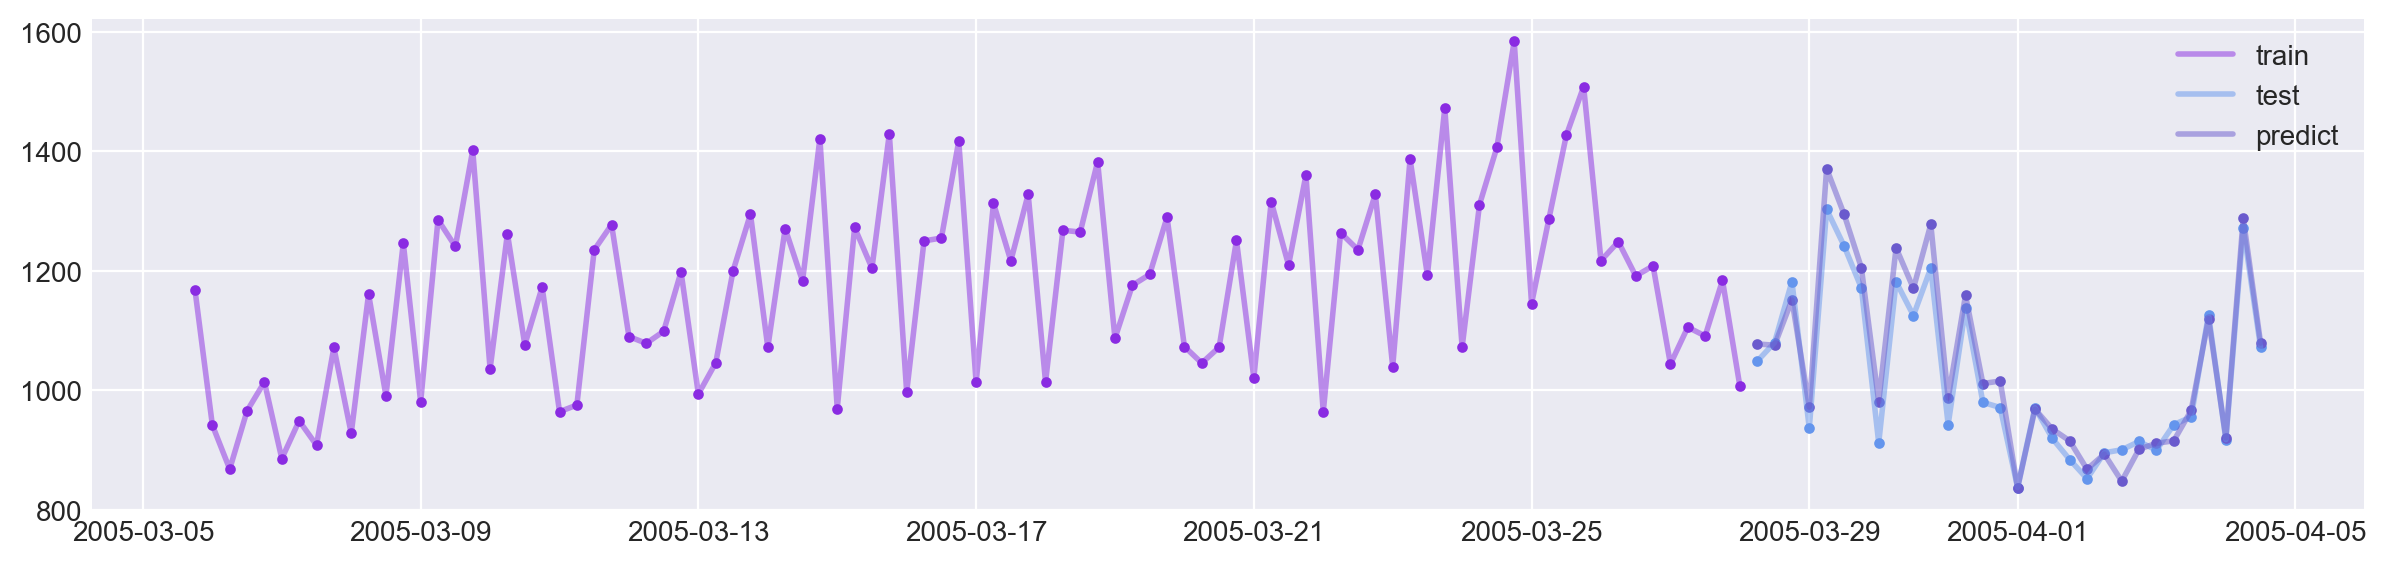

In [26]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [27]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [28]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 27s 71ms/step - loss: 143949.3594 - mae: 221.9031 - val_loss: 5230.5884 - val_mae: 63.9832
Epoch 2/20
200/200 [==============================] - 13s 67ms/step - loss: 3719.3103 - mae: 47.5233 - val_loss: 921.9169 - val_mae: 23.9324
Epoch 3/20
200/200 [==============================] - 13s 64ms/step - loss: 3848.2847 - mae: 41.1174 - val_loss: 4492.1436 - val_mae: 59.4465
Epoch 4/20
200/200 [==============================] - 12s 61ms/step - loss: 2532.0054 - mae: 37.6207 - val_loss: 1299.9857 - val_mae: 29.3127
Epoch 5/20
200/200 [==============================] - 12s 61ms/step - loss: 1976.5537 - mae: 35.3646 - val_loss: 2118.9141 - val_mae: 37.7460
Epoch 6/20
200/200 [==============================] - 12s 60ms/step - loss: 1683.9585 - mae: 32.5236 - val_loss: 4219.7031 - val_mae: 57.0816
Epoch 7/20
200/200 [==============================] - 7s 33ms/step - loss: 1564.8043 - mae: 31.3400 - val_loss: 898.3445 - val_mae: 24.3044
Epoch 

In [44]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

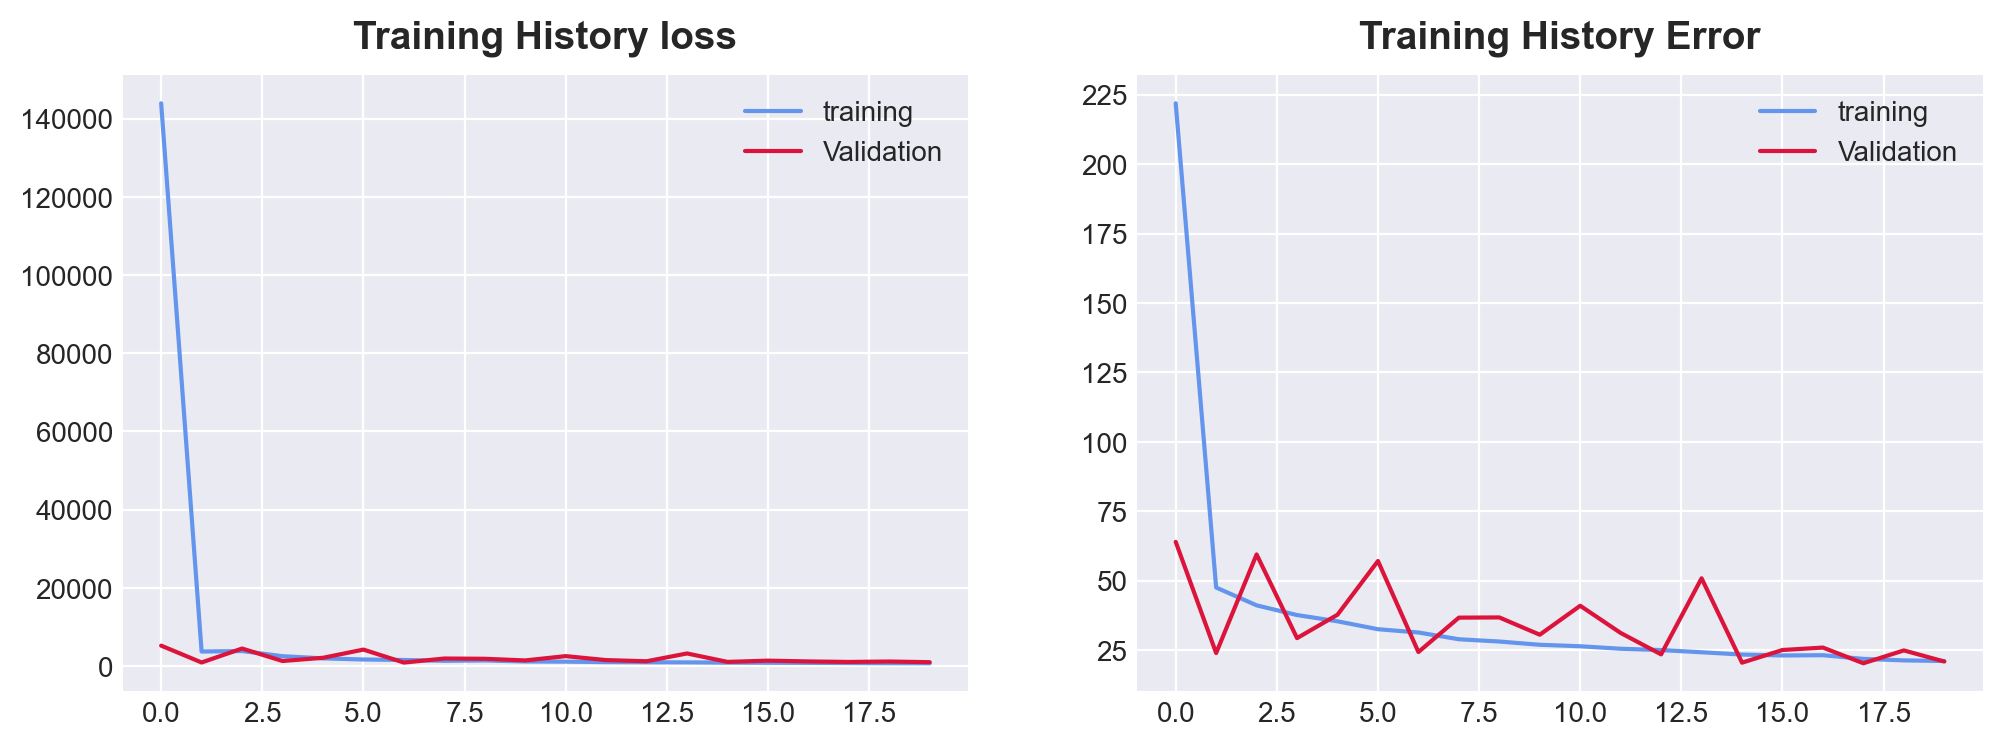

In [45]:
plot_tf_training_history(training_history)

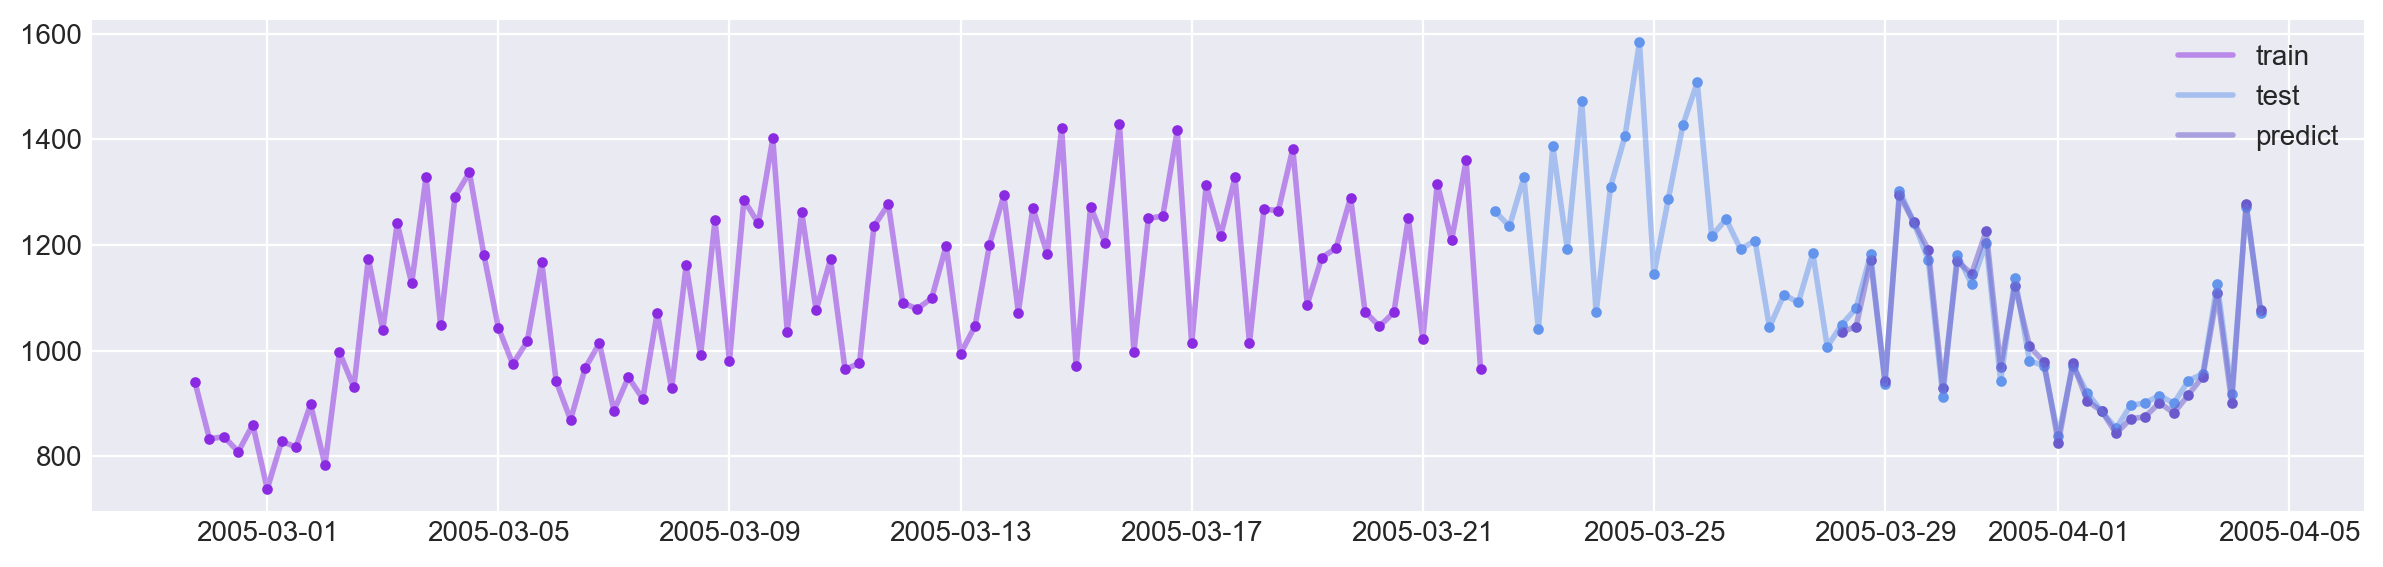

In [46]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [47]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,79.894444,9.916667,12.036102,31.227083,31.502607,30.513664,28.513243,20.888939
rmse,94.498003,38.617270,32.935860,37.079133,35.722256,36.479774,35.660690,31.570075
mape,0.080879,0.009331,0.011616,0.030586,0.030792,0.029707,0.027246,0.018208
r2,0.504966,0.917329,0.939865,0.923784,0.929260,0.926228,0.929503,0.969425


In [48]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,79.894444,94.498003,0.080879,0.504966
BayesianRidge,9.916667,38.617270,0.009331,0.917329
LassoCV,12.036102,32.935860,0.011616,0.939865
RandomForestRegressor,31.227083,37.079133,0.030586,0.923784
XGBRegressor,31.502607,35.722256,0.030792,0.929260
LGBMRegressor,30.513664,36.479774,0.029707,0.926228
CatBoostRegressor,28.513243,35.660690,0.027246,0.929503
LSTM_Dense,20.888939,31.570075,0.018208,0.969425


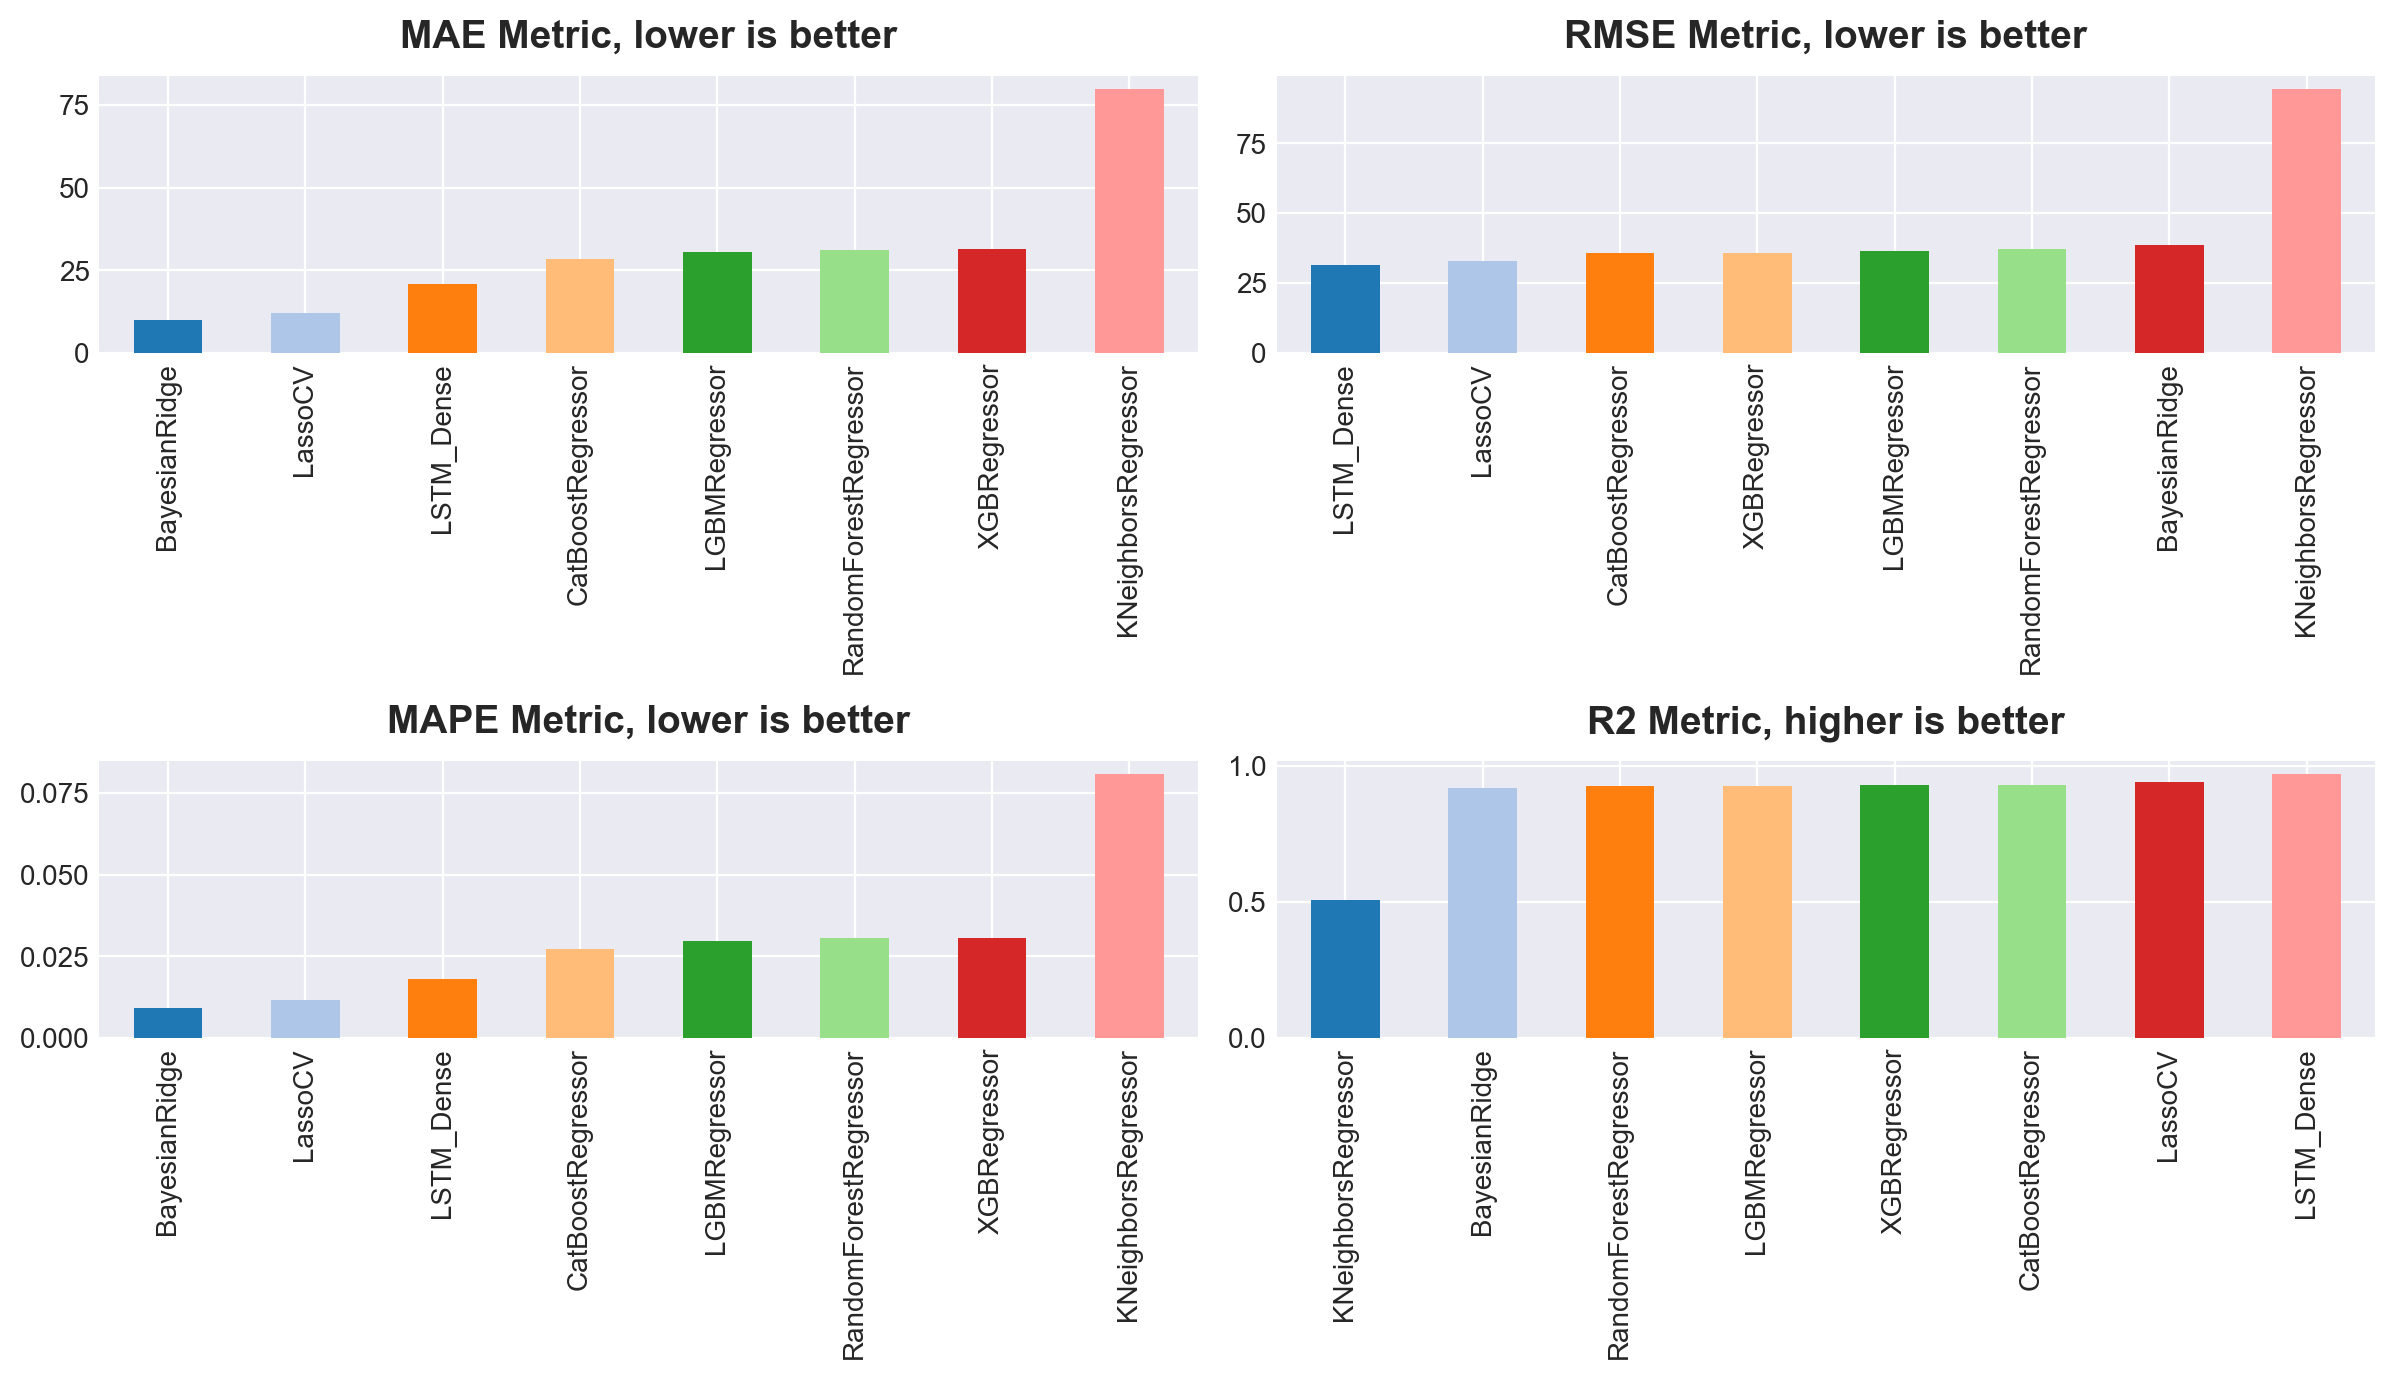

In [49]:
plot_metrics(resultsDF)

In [50]:
resultsDF.T["dataset"] = "air_quality"
resultsDF.T["Mode"] = "Singel_step"

resultsDF.T.to_csv("./air_quality_results.csv", index=False)